In [27]:
%run ./const
%run ./param
import sys
import csv
import numpy as np
import glob
from scipy import integrate, interpolate
import matplotlib
import math
import copy
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['lines.dash_capstyle'] = "round"
matplotlib.rcParams['lines.solid_capstyle'] = "round"
matplotlib.rcParams['legend.handletextpad'] = 0.4

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{cmbright}  \usepackage[T1]{fontenc}')

matplotlib.rcParams['axes.linewidth'] = 0.6
matplotlib.rcParams['ytick.major.width'] = 0.6
matplotlib.rcParams['xtick.major.width'] = 0.6
matplotlib.rcParams['ytick.minor.width'] = 0.45
matplotlib.rcParams['xtick.minor.width'] = 0.45
matplotlib.rcParams['ytick.major.size'] = 2.75
matplotlib.rcParams['xtick.major.size'] = 2.75
matplotlib.rcParams['ytick.minor.size'] = 1.75
matplotlib.rcParams['xtick.minor.size'] = 1.75
matplotlib.rcParams['legend.handlelength'] = 1.5

import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import ListedColormap
import palettable
from scipy.integrate import ode
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy import optimize
import cmasher as cmr
import matplotlib.font_manager
from numpy import random
from scipy.stats import lognorm
from scipy.stats import norm
import scipy.optimize as opt

from scipy.sparse import diags
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from ipynb.fs.full.utils import Matrix3D
import time

###########################
gamma   = 5/3.
kb      = 1.3806488e-16
mp      = 1.67373522381e-24
km      = 1e5
s       = 1
yr      = 3.1536e7
Myr     = 3.1536e13
Gyr     = 3.1536e16
pc      = 3.086e18
kpc     = 1.0e3 * pc
Mpc     = 1.0e6 * pc
H0      = 67.74*km/s/Mpc
Om      = 0.3075
OL      = 1 - Om
G       = 6.673e-8
Msun    = 2.e33
fb      = 0.158
keV     = 1.60218e-9
###########################


###########################
mu          = 0.62
metallicity = 10**-2  #10**-0.5
muH         = 1/0.75
###########################

const = Const()
pm = Param("Inputs", const).paramDict



In [28]:
class FrozenDict(dict):
    def __init__(self, *args, **kwargs):
        self._frozen = False
        dict.__init__(self, *args, **kwargs)
    def freeze(self):
        self._frozen = True
    def __setitem__(self, key, value):
        if (self._frozen):
            raise TypeError("Attempted assignment to a frozen dict")
        else:
            return dict.__setitem__(self, key, value)

In [29]:
class EvolveControl:
    def __init__(self, const, pm):
        self.r_start = pm['R_START']
        self.r_min = pm['R_MIN']
        r_delta = pm['R_DELTA']
        r_steps = pm['R_STEPS']
        self.sonic_point = pm['SONIC_POINT']
        self.r_wind = self.r_start
        self.r_cloud = self.r_start
        self.dr_schedule = [r_delta for i in range(r_steps+1)]
        r_bndry = np.array([self.r_start - self.dr_schedule[0]/2])
        for dr in self.dr_schedule:
            r_bndry = np.append(r_bndry, r_bndry[-1]+dr)
        r_schedule = (r_bndry[:-1] + r_bndry[1:])/2
#        r_schedule = pm['CUSTOM_SCHEDULE']
        self.dr = r_schedule[1:]-r_schedule[:-1]
        self.dvol_schedule = 4 / 3 * np.pi * (r_bndry[1:]**3 - r_bndry[:-1]**3)
        self.r_schedule = r_schedule
        self.wind_i=0
        self.cloud_i=0
        self.cfl_m0 = []
        self.cfl_m1 = []
        self.cfl_v0 = []
        self.cfl_v1 = []
        self.delta_r = 0
            
    def get_wind_r_info(self):
        if pm['CUST_SCHEDULE'] == 1:
            r_curr = self.r_schedule[self.wind_i]
            r_next = self.r_schedule[self.wind_i + 1]
            dr = self.dr[self.wind_i]
#            dvol = self.dvol_schedule[self.wind_i] 
        else:
            r_curr = self.r_wind
            r_next = r_curr + self.delta_r
            dr = self.delta_r
#            dvol = 4/3 * np.pi * (r_next**3 - r_curr**3)             
        return r_curr, r_next, dr, # dvol

    def get_cloud_r_info(self):
        if pm['CUST_SCHEDULE'] == 1:
            r_curr = self.r_schedule[self.wind_i]
            r_next = self.r_schedule[self.wind_i + 1]
            dr = self.dr[self.wind_i]
#            dvol = self.dvol_schedule[self.wind_i] 
        else:
            r_curr = self.r_cloud
            r_next = r_curr + self.delta_r
            dr = self.delta_r
#            dvol = 4/3 * np.pi * (r_next**3 - r_curr**3)             
        return r_curr, r_next, dr #dvol        

#    def get_windr_info(self):
#        r_curr = self.r_schedule[self.wind_i]
#        r_next = self.r_schedule[self.wind_i + 1]
#        dr = self.dr[self.wind_i]
#        dvol = self.dvol_schedule[self.wind_i]
#        return r_curr, r_next, dr, dvol
        
#    def get_cloudr_info(self):
#        r_curr = self.r_schedule[self.cloud_i]
#        r_next = self.r_schedule[self.cloud_i + 1]
#        dr = self.dr[self.cloud_i]
#        dvol = self.dvol_schedule[self.cloud_i]
#        return r_curr, r_next, dr, dvol

In [30]:
class Cooling:
    def __init__(self, fname, const):
        file = glob.glob(fname) ## CHANGE FOR WHERE YOU WANT TO KEEP IT
        if len(file) > 0:
            data = np.load(file[0])
            Lambda_tab = data['Lambda_tab']
            redshifts  = data['redshifts']
            Zs         = data['Zs']
            log_Tbins  = data['log_Tbins']
            log_nHbins = data['log_nHbins']    
            self.Lambda     = interpolate.RegularGridInterpolator((log_nHbins,log_Tbins,Zs,redshifts), Lambda_tab, bounds_error=False, fill_value=1e-30)
            self.Lambda_cool = lambda T,Z : 5e-22 * (T/2e5)**np.where(T>2e5, -2/3., 1/2.) * Z
        else:
            print("Cooling curve file not found")
            
    def tcool_P(self, T,P,Z):
        mu = const.mu
        muH = const.muH
        T = np.where(T>10**8.98, 10**8.98, T)
        T = np.where(T<10**2, 10**2, T)
        nH_actual = P/T*(mu/muH)
        nH = np.where(nH_actual>1, 1, nH_actual)
        nH = np.where(nH<10**-8, 10**-8, nH)
        return 1.5 * (muH/mu)**2 * kb * T / ( nH_actual * self.Lambda((np.log10(nH),np.log10(T), Z,0)))

In [31]:
class Transfer:
    
    drag_coeff = pm['DRAG_COEFF']
    M_cloud_min = pm['M_CLOUD_MIN']
    
    def __init__(self, const, pm):
        self.wind_info = ()
        self.wind_source = {}
        self.wind_dot_info = ()
#        self.cloudFD_retire = np.array([])
        self.lived_clouds_MC = []
        self.retired_clouds_MC = []
        self.cloud_info = {}
        self.cloud_live = {}
        self.cloud_retire = {}
        self.wind = {}
        return

    def update_wind_source(self, rho_dot, p_dot, e_dot, rhoZ_dot):
        self.wind_source['rho'] = rho_dot
        self.wind_source['p'] = p_dot
        self.wind_source['e'] = e_dot
        self.wind_source['rhoZ'] = rhoZ_dot
        return
     
    def update_cloud(self, Mdot_grow, Mdot_loss, cloud_live, cloud_retire):
        self.cloud_live['M']=cloud_live['M']
        self.cloud_live['v']=cloud_live['v']
        self.cloud_live['n']=cloud_live['n']
        self.cloud_live['Z']=cloud_live['Z']        
        self.cloud_live['Mdot_grow'] = Mdot_grow
        self.cloud_live['Mdot_loss'] = Mdot_loss        
        self.cloud_retire['M'] = cloud_retire['M']
        self.cloud_retire['v'] = cloud_retire['v']
        self.cloud_retire['n'] = cloud_retire['n']
        self.cloud_retire['Z'] = cloud_retire['Z']        
        return
    
    def update_wind(self, v, rho, P, rhoz):
        self.wind['v'] = v
        self.wind['rho'] = rho
        self.wind['P'] = P
        self.wind['rhoZ'] = rhoz
        return
    
    def read_cloud_info(self):
        return Utils.ntuple2array(self.cloud_info)       
    
    
    def update_wind_dot_info(self, rho_dot, p_dot, epsilon_dot, rhoz_dot):
        data = (rho_dot, p_dot, epsilon_dot, rhoz_dot)
        self.wind_dot_info = data
        return
    def read_wind_dot_info(self):
        rho_dot, p_dot, epsilon_dot, rhoz_dot = self.wind_dot_info
        return rho_dot, p_dot, epsilon_dot, rhoz_dot

    def update_lived_clouds_MC(self, data):
        self.lived_clouds_MC = Utils.array2ntuple(data)
        return
    def read_lived_clouds_MC(self):
        return Utils.ntuple2array(self.lived_clouds_MC)
    
    
    def update_retired_clouds_MC(self, data):
        self.retired_clouds_MC = Utils.array2ntuple(data)
        return
    def read_retired_clouds_MC(self):
        return Utils.ntuple2array(self.retired_clouds_MC)

    def update_wind_info(self, v, rho, P, rhoz):
        data = (v, rho, P, rhoz)
        self.wind_info = data
        return
    def read_wind_info(self):
        v, rho, P, rhoz = self.wind_info
        return v, rho, P, rhoz
    
    def calcSource(self, Mdot_grow, Mdot_loss, pdot_drag, vesc_sqr, cloud_info, rho_cloud, aux_params):  
        v, rho, P, rhoz = self.read_wind_info()
        Z_wind = rhoz / rho
        M_cloud, v_cloud, n_cloud, Z_cloud = Utils.ntuple2array(cloud_info)
        dr, dvol, gamma, retire_mass, retire_flag = aux_params
        
        dt = abs(dr/v_cloud)
        Mdot_grow = np.where(M_cloud < retire_mass, 0, Mdot_grow)
        Mdot_loss = np.where(M_cloud < retire_mass, M_cloud/dt, Mdot_loss)
        dpdt_drag = n_cloud * pdot_drag
        rho_dot_plus = Mdot_loss * n_cloud
        rho_dot_minus = Mdot_grow * n_cloud
        rho_dot = rho_dot_plus - rho_dot_minus
        p_dot = rho_dot_plus*v_cloud - rho_dot_minus*v - dpdt_drag
        vB_2 = 0.5 * v**2 + gamma / (gamma - 1) * P / rho - 0.5 * vesc_sqr
        vB_cloud_2 = 0.5 * v_cloud**2 + gamma / (gamma - 1) * P / rho_cloud - 0.5 * vesc_sqr
        epsilon_dot = rho_dot_plus * vB_cloud_2 - rho_dot_minus * vB_2 - dpdt_drag * v_cloud
        rhoz_dot = Z_cloud * rho_dot_plus - Z_wind * rho_dot_minus  
        return rho_dot, p_dot, epsilon_dot, rhoz_dot

    def calc_wind_source(self, Phir, cloud):
        v = self.wind['v']
        rho = self.wind['rho']
        P = self.wind['P']
        rhoz = self.wind['rhoZ']
        Mdot_grow = cloud['Mdot_grow']
        Mdot_loss = cloud['Mdot_loss']
        M_cloud = cloud['M']
        v_cloud = cloud['v']
        n_cloud = cloud['n']
        Z_cloud = cloud['Z']
        rho_cloud = cloud['rho']
        r_cloud = cloud['r']
        p_dot_drag = cloud['pdot_drag']
        
        Z_wind = rhoz / rho
        dpdt_drag    = (n_cloud * p_dot_drag)        
        rho_dot_plus = Mdot_loss * n_cloud
        rho_dot_minus = Mdot_grow * n_cloud
        rho_dot = rho_dot_plus - rho_dot_minus
        p_dot = rho_dot_plus*v_cloud - rho_dot_minus*v - dpdt_drag
        vB_2 = 0.5 * v**2 + gamma / (gamma - 1) * P / rho + Phir
        vB_cloud_2 = 0.5 * v_cloud**2 + gamma / (gamma - 1) * P / rho_cloud + Phir
        epsilon_dot = rho_dot_plus * vB_cloud_2 - rho_dot_minus * vB_2 - dpdt_drag * v_cloud
        rhoz_dot = Z_cloud * rho_dot_plus - Z_wind * rho_dot_minus 
        if dump_source == 1: print(rho_dot, p_dot, epsilon_dot, rhoz_dot)
        return rho_dot, p_dot, epsilon_dot, rhoz_dot 


    def updateSource(self, r, dr, pm):
        _, Phir, _ = Utils.get_vcir2_Phi_vesc2(r,pm)
        retire = copy.deepcopy(self.cloud_retire)
        retire['rho'], retire['r'], retire['pdot_drag'] = Utils.get_cloud_rho_r_pdotdrag(self.wind, retire, const, pm)
#        M_cloud_r = self.cloud_retire['M']
#        v_cloud_r = self.cloud_retire['v']
#        n_cloud_r = self.cloud_retire['n']
#        Z_cloud_r = self.cloud_retire['Z']
        dt = abs(dr / retire['v'])
        retire['Mdot_loss'] = retire['M']/dt
        retire['Mdot_grow'] = 0
        rho_dot0, p_dot0, e_dot0, rhoZ_dot0 = self.calc_wind_source(Phir, retire)
        
        live = copy.deepcopy(self.cloud_live)
        live['rho'], live['r'], live['pdot_drag'] = Utils.get_cloud_rho_r_pdotdrag(self.wind, live, const, pm)
        rho_dot1, p_dot1, e_dot1, rhoZ_dot1 = self.calc_wind_source(Phir, live)
        
        rho_dot = sum(rho_dot0) + sum(rho_dot1)
        p_dot = sum(p_dot0) + sum(p_dot1)
        e_dot = sum(e_dot0) + sum(e_dot1)
        rhoZ_dot = sum(rhoZ_dot0) + sum(rhoZ_dot1)
        
        self.update_wind_source(rho_dot, p_dot, e_dot, rhoZ_dot)
         
        return rho_dot, p_dot, e_dot, rhoZ_dot
        
        
        
        
    
    def updateSourceMC(self, Mdot_grow, Mdot_loss, pdot_drag, vesc_sqr, cloud_info, rho_cloud, aux_params):

        # retired clouds as source
        if (len(self.retired_clouds_MC) == 0):
            rho_dot_retired = 0.
            p_dot_retired = 0.
            epsilon_dot_retired = 0.
            rhoz_dot_retired = 0.
        else:
            rhodot, pdot, epsilondot, rhozdot = self.calcSource(0, 0, 0, 0, self.retired_clouds_MC, rho_cloud, aux_params)
            rho_dot_retired = sum(rhodot)
            p_dot_retired = sum(pdot)
            epsilon_dot_retired = sum(epsilondot)
            rhoz_dot_retired = sum(rhozdot)

        
        # live clouds as source
        rhodot, pdot, epsilondot, rhozdot = self.calcSource(Mdot_grow, Mdot_loss, pdot_drag, vesc_sqr, cloud_info, rho_cloud, aux_params)
        
        rho_dot_lived = sum(rhodot)
        p_dot_lived = sum(pdot)
        epsilon_dot_lived = sum(epsilondot)
        rhoz_dot_lived = sum(rhozdot)
 

        self.update_wind_dot_info(rho_dot_retired + rho_dot_lived,
                                  p_dot_retired + p_dot_lived,
                                  epsilon_dot_retired + epsilon_dot_lived, 
                                  rhoz_dot_retired + rhoz_dot_lived)
        
        return

    def updateSourceFD(self, Mdot_grow, Mdot_loss, pdot_drag, rho_cloud, dmdv, aux_params):
#        rhodot, pdot, epsilondot, rhozdot = self.calcSource(Mdot_grow, Mdot_loss, self.cloudFD_retire, rho_cloud, aux_params)
#        self.rho_dot = -sum(rhodot * dmdv)
#        self.p_dot = -sum(pdot * dmdv)
#        self.epsilon_dot = -sum(epsilondot * dmdv)
#        self.rhozdot = -sum(rhozdot * dmdv)

        (_, dvol, _,_,_) = aux_params
    
        M,v,f,z = Utils.ntuple2array(self.retired_clouds_MC)
        f /= dvol
        retired_clouds = Utils.array2ntuple((M,v,f,z))        
        rhodot, pdot, epsilondot, rhozdot = self.calcSource(Mdot_grow, Mdot_loss, pdot_drag, retired_clouds, rho_cloud, aux_params)
        rho_dot_retired = sum(rhodot * dmdv)
        p_dot_retired = sum(pdot * dmdv)
        epsilon_dot_retired = sum(epsilondot * dmdv)
        rhoz_dot_retired = sum(rhozdot * dmdv)

        M,v,f,z = Utils.ntuple2array(self.lived_clouds_MC)
        f /= dvol
        lived_clouds = Utils.array2ntuple((M,v,f,z))        
        rhodot, pdot, epsilondot, rhozdot = self.calcSource(Mdot_grow, Mdot_loss, pdot_drag, lived_clouds, rho_cloud, aux_params)
        rho_dot_lived = sum(rhodot * dmdv)
        p_dot_lived = sum(pdot * dmdv)
        epsilon_dot_lived = sum(epsilondot * dmdv)
        rhoz_dot_lived = sum(rhozdot * dmdv)
        
        self.update_wind_dot_info(rho_dot_retired + rho_dot_lived,
                                  p_dot_retired + p_dot_lived,
                                  epsilon_dot_retired + epsilon_dot_lived, 
                                  rhoz_dot_retired + rhoz_dot_lived)
        return

        

In [32]:
class Utils:
    
    @staticmethod
    def genGrid(xmin, xmax, nbs, log, unit):
        delta = (xmax - xmin)/nbs
        boundary = [xmin]
        for i in range(nbs):
            boundary.append(xmin+(i+1)*delta)
        boundary = np.array(boundary)
        if (log==True):
            bndry = 10**boundary * unit
        else:
            bndry = boundary * unit
        center = np.array([0.5 * (bndry[i] + bndry[i+1])for i in range(nbs)])
        delta = np.array([bndry[i+1] - bndry[i] for i in range(nbs)])
        return center, bndry, delta

    @staticmethod
    def pseudo_lognormal(bmin, bmax, nbs_bins, mu, sigma, unit, mtotal):
        bin_size = (bmax-bmin)/(nbs_bins+2)
        logbins = np.arange(bmin,bmax,bin_size)
        bins = 10**logbins * unit
        mu = mu + np.log10(unit)
        z=(np.log10(bins[1:-1])-mu)/sigma
        f = 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*z**2)
        _delta = bins[1:]-bins[:-1]
        delta_b = _delta[:-1]
        delta_f = _delta[1:]
        return f, bins[1:-1], delta_b, delta_f     
    
    @staticmethod    
    def lognormal(bmin, bmax, nbs_bins, mu, sigma, unit):
        center, bndry, delta = Utils.genGrid(bmin, bmax, nbs_bins, True, unit) 
        mu = mu + np.log10(unit)
        z=(np.log10(center)-mu)/sigma
#        f = np.log10(np.e) / ( center * sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*z**2)
        f = 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*z**2)
        return f, center, delta, bndry            

    @staticmethod
    def normal(bmin, bmax, nbs_bins, mu, sigma, unit):
        center, bndry, delta = Utils.genGrid(bmin, bmax, nbs_bins, False, unit)
        z = (center/unit - mu)/(sigma)
        f=1/(sigma * unit * np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2) 
        return f, center, delta, bndry        
    
    @staticmethod
    def gen_uniform_dist(nbsample, mini, maxi, unit):
        return random.uniform(mini, maxi, nbsample)*unit

    @staticmethod
    def gen_lognormal_dist(nbsample, logmean, logstd, unit):
        sample=random.normal(logmean, logstd, nbsample)
        return 10 ** sample * unit

    @staticmethod
    def gen_normal_dist(nbsample, mean, std, unit):
        sample=random.normal(mean, std, nbsample)
        return sample * unit

    @staticmethod
    def gen_powerlaw(nbsample, xmin, xmax, power, unit):
        r = np.random.random(size=nbsample)
        ag, bg = xmin**power, xmax**power
        return (ag + (bg - ag)*r) ** (1./power) * unit    

    @staticmethod
    def gen_normal_weighted(nbsample, mu, sigma, cutoff, unit):
        mu *= unit
        sigma *= unit
        cutoff *= unit
        xmin_nocutoff = mu-4*sigma
        xmin = np.where(xmin_nocutoff < cutoff, cutoff, xmin_nocutoff)
        xmax = mu+4*sigma
        u = (xmax-xmin) * np.random.random(size=nbsample) + xmin
        n = 1/(sigma * unit * np.sqrt(2*np.pi)) * np.exp(-0.5*((u-mu)/sigma)**2)
        return u, n

    @staticmethod
    def gen_powerlaw_weighted(nbsample, xmin, xmax, power, unit):
        logr = (xmax-xmin) * np.random.random(size=nbsample) + xmin
        r = 10**logr * unit
        b = 10**xmax * unit
        a = 10**xmin * unit
        power += 1
        n = power * r**(power-1) / (b**power - a**power) 
        return r, n  

    @staticmethod    
#    def dot_cloud_calc(r, Pressure, v_wind, rho_wind, rhoz_wind, M_cloud, v_cloud, Z_cloud, tcool_P, pm):   
    def dot_cloud_calc(wind, cloud, tcool_P, pm):   
        # cloud transfer rates
        T_cloud = pm['CLOUD_TEMP']
        f_turb0 = pm['F_TURB0']
        TurbulentVelocityChiPower = pm['TURBULENT_VELOCITY_CHI_POWER'] 
        geometric_factor  = pm['GEOMETRIC_FACTOR']
        CoolingAreaChiPower  = pm['COOLING_AREA_CHI_POWER']
        ColdTurbulenceChiPower = pm['COLD_TURBULENCE_CHI_POWER'] 
        Mdot_coefficient = pm['MDOT_COEFFICIENT']
        drag_coeff = pm['DRAG_COEFF']
        vc = pm['V_CIR']
        M_cloud_min = pm['M_CLOUD_MIN']
        retire_mass = pm['RETIREMENT_MASS']

        Pressure = wind['P']
        v_wind = wind['v']
        rho_wind = wind['rho']
        rhoz_wind = wind['rhoZ']
        
        M_cloud = cloud['M']
        v_cloud = cloud['v']
        Z_cloud = cloud['Z']
        Z_wind = rhoz_wind / rho_wind
        rho_cloud    = Pressure * (mu*mp) / (kb*T_cloud) # + [0]*M_cloud # cloud in pressure equilibrium
        chi          = rho_cloud / rho_wind
        r_cloud      = (M_cloud / ( 4*np.pi/3. * rho_cloud))**(1/3.) 
        v_rel        = (v_wind-v_cloud)
        v_turb0       = f_turb0 * v_rel * chi**TurbulentVelocityChiPower
        v_turb       = np.where(v_turb0 <=0, 0.001, v_turb0)
        T_wind       = Pressure/kb * (mu*mp/rho_wind)
        T_mix        = (T_wind*T_cloud)**0.5
        Z_mix        = (Z_wind*Z_cloud)**0.5
        t_cool_layer = tcool_P(T_mix, Pressure/kb, Z_mix/const.ZSun)[()] 
        t_cool_layer = np.where(t_cool_layer<0, 1e10*Myr, t_cool_layer)
#        t_cool_layer = 1*Myr
        ksi          = r_cloud / (v_turb * t_cool_layer)
        AreaBoost    = geometric_factor * chi**CoolingAreaChiPower
        v_turb_cold  = v_turb * chi**ColdTurbulenceChiPower
        Mdot_grow    = Mdot_coefficient * 3.0 * M_cloud * v_turb * AreaBoost / (r_cloud * chi) * np.where( ksi < 1, ksi**0.5, ksi**0.25 )
        Mdot_loss    = Mdot_coefficient * 3.0 * M_cloud * v_turb_cold / r_cloud 
        Mdot_cloud   = np.where(M_cloud > M_cloud_min, Mdot_grow - Mdot_loss, 0) 
        if dump_Mdot == 1: print(Mdot_grow, Mdot_loss)
        return Mdot_grow, Mdot_loss, rho_cloud, r_cloud   

    
    def dot_cloud_calc1(wind, cloud, tcool_P, pm):        
        T_cloud = pm['CLOUD_TEMP']
        f_turb0 = pm['F_TURB0']
        Mdot_chi_power = pm['MDOT_CHI_POWER']

        
        P = wind['P']
        v = wind['v']
        rho = wind['rho']
        
        M_cloud = cloud['M']
        v_cloud = cloud['v']
        
        Lambda_cool = lambda T : 5e-22 * (T/2e5)**np.where(T>2e5, -2/3., 1/2.)        
        # cloud_radius(M_cloud,v_cloud):
        rho_cloud   = P * (mu*mp) / (kb*T_cloud) # cloud in pressure equilibrium
        chi         = rho_cloud / rho

        r_cloud     = (M_cloud / (rho_cloud))**(1/3.) 
        # layer_turbulent_velocity(M_cloud,v_cloud):
        
        v_turb0      = f_turb0*(v-v_cloud)
        v_turb = np.where(v_turb0 <=0, 0.001, v_turb0)
                
        T_wind  = P/kb * (mu*mp/rho)
        T_mix   = np.sqrt(T_wind*T_cloud)

        # layer_cooling_time
        T = T_mix
        T = np.where(T>10**8.98, 10**8.98, T)
        T = np.where(T<10**2, 10**2, T)
        nH_actual = P/kb/T*(mu/muH)
        nH = np.where(nH_actual>1, 1, nH_actual)
        nH = np.where(nH<10**-8, 10**-8, nH)
        t_cool_layer = 1.5 * (muH/mu)**2 * kb * T / ( nH_actual * Lambda_cool(T_mix))        

#        t_cool_layer = 1.5 * (muH/mu)**2 * kb * T / ( nH_actual * self.Lambda((np.log10(nH),np.log10(T), metallicity,0)))        
#        t_cool_layer = self.cool.tcool_P(T_mix, P/kb, self.metallicity, self.mu, self.muH)    
#        t_cool_layer = self.t_cool_layer    

        # cloud_ksi(M_cloud,v_cloud):        
        ksi     = r_cloud / (v_turb * t_cool_layer)

        # Mdot_cloud_grow(M_cloud,v_cloud):
        Mdot_grow   =  3 * M_cloud * v_turb / (r_cloud * chi**Mdot_chi_power) * np.where( ksi < 1, ksi**0.5, ksi**0.25 )
        Mdot_loss   = -3 * M_cloud * v_turb / (r_cloud * chi**Mdot_chi_power) 
        force_from_transfer = (v-v_cloud)*Mdot_grow

        Mdot = (Mdot_grow + Mdot_loss)
        vdot = (force_from_transfer/M_cloud)
        return Mdot_grow, Mdot_loss, rho_cloud, r_cloud  
    
    
    
    
    @staticmethod
    def get_cloud_rho_r_pdotdrag(wind, cloud, const, pm):
        T_cloud = pm['CLOUD_TEMP']
        drag_coeff = pm['DRAG_COEFF']
        M_cloud_min = pm['M_CLOUD_MIN']

        Pressure = wind['P']
        v_wind = wind['v']
        rho_wind = wind['rho']
        M_cloud = cloud['M']
        v_cloud = cloud['v']
        rho_cloud    = Pressure * (mu*mp) / (kb*T_cloud) # + [0]*M_cloud # cloud in pressure equilibrium
        r_cloud      = (M_cloud / ( 4*np.pi/3. * rho_cloud))**(1/3.) 
        v_rel = v_wind - v_cloud
        pdot_drag   = 0.5 * drag_coeff * rho_wind * np.pi * v_rel**2 * r_cloud**2 * np.where(M_cloud>M_cloud_min, 1, 0)
        return rho_cloud, r_cloud, pdot_drag
    
    @staticmethod
    def get_Mdot_vdot_Zdot(r, Mdot_grow, Mdot_loss, wind, cloud, pm):
        rho_cloud, r_cloud, pdot_drag = Utils.get_cloud_rho_r_pdotdrag(wind, cloud, const, pm)
        M_cloud_min = pm['M_CLOUD_MIN']
        v_wind = wind['v']
        rho_wind = wind['rho']
        rhoZ_wind = wind['rhoZ']
        M_cloud = cloud['M']
        v_cloud = cloud['v']
        Z_cloud = cloud['Z']
        (vc_sqr, _, _) = Utils.get_vcir2_Phi_vesc2(r, pm)
        Mdot = (Mdot_grow - Mdot_loss)
        v_rel = v_wind - v_cloud
        vdot = (pdot_drag + v_rel*Mdot_grow - M_cloud * vc_sqr/r) / M_cloud * np.where(M_cloud>M_cloud_min, 1, 0)
        Z_wind = rhoZ_wind / rho_wind
#        Mdot_Z = Z_wind * Mdot_grow + Z_cloud * Mdot_loss
#        Zdot = (Mdot_Z - Z_cloud * Mdot)/M_cloud
        Zdot = (Z_wind-Z_cloud) * Mdot_grow / M_cloud
        return Mdot, vdot, Zdot, pdot_drag
    
    
    

        
    @staticmethod
    def retireCloud(clouds, pm):
        retire_mass = pm['RETIREMENT_MASS']
        M_clouds = clouds['M']
        v_clouds = clouds['v']
        n_clouds = clouds['n']
        z_clouds = clouds['Z']
        M_clouds = np.where(M_clouds <=retire_mass, retire_mass, M_clouds)  #assume the mass of retired cloud to retire mass 
        cloud_stack = np.column_stack((M_clouds, v_clouds, n_clouds, z_clouds))
        cloud_live = np.array([list(item) for item in cloud_stack if item[0] > retire_mass])
        cloud_retire = np.array([list(item) for item in cloud_stack if item[0] <= retire_mass])
        if cloud_retire.size == 0: cloud_retire = np.array([[0,1e-100,0,0]])
        return cloud_live, cloud_retire

    
    @staticmethod        
    def read_cloud(cloud):
        return cloud['M'], cloud['v'], cloud['n'], cloud['Z']
    @staticmethod            
    def read_wind(wind):
        return wind['v'], wind['rho'], wind['P'], wind['rhoZ']

    @staticmethod        
    def write_cloud(M, v, n, Z):
        cloud={}
        cloud['M'] = M
        cloud['v'] = v
        cloud['n'] = n
        cloud['Z'] = Z
        return cloud
    @staticmethod            
    def write_wind(v, rho, P, rhoZ):
        wind={}
        wind['v'] = v
        wind['rho'] = rho
        wind['P'] = P
        wind['rhoZ'] = rhoZ
        return wind
    
    
    
    @staticmethod        
    def getdr_MC(CLF_MC, cloud, Mdot_grow, Mdot_loss): 
        M_clouds, v_clouds, _, _ = Utils.read_cloud(cloud)
        Mdot = Mdot_grow - Mdot_loss
        dr_M = CLF_MC * min(abs(M_clouds * v_clouds / Mdot))
        return dr_M

    @staticmethod
    def binnings_MC(i, res, cloud):
        v_bins = cloud.vbndry
        M_bins = cloud.mbndry
#        clouds = res.clouds[i]
        clouds = res.clouds_MC[i]
        
        nbs_vbin= len(v_bins)
        nbs_Mbin= len(M_bins)

        M_cloud = np.tile(M_bins, nbs_vbin)
        v_cloud = np.repeat(v_bins, nbs_Mbin)

        f=np.reshape(np.zeros(nbs_vbin * nbs_Mbin),(nbs_vbin,nbs_Mbin))
        v_min = v_bins[0]
        v_max = v_bins[nbs_vbin-1]
        M_min = M_bins[0]
        M_max = M_bins[nbs_Mbin-1]
        for item in clouds:
            if (item[1]>=v_min) and (item[1]<=v_max) and (item[0]>=M_min) and (item[0]<=M_max):
                v_idx = np.max(np.where(v_bins <= item[1]))
                M_idx = np.max(np.where(M_bins <= item[0]))
                f[v_idx][M_idx]+=item[2]
        return f, M_bins, v_bins

    @staticmethod
    def array2ntuple(array):
        return list(zip(*array))

    @staticmethod
    def ntuple2array(ntuple):
        return [np.array(item) for item in list(zip(*ntuple))]    
    
    
    @staticmethod
    def get_vcir2_Phi_vesc2(r, pm):
        v_circ0 = pm['V_CIR']
        r0 = pm['SONIC_POINT']
        r1 = pm['R_START']
#        print(r/pc)
        vc_sqr = v_circ0**2 * np.where(r<r0, 0, 1.0)        
        Phir = vc_sqr * np.where(r<r0, 0.5 * (r/r0)**2, np.log(r/r0)) 
        vesc_sqr = -2 * Phir
        return vc_sqr, Phir, vesc_sqr


In [33]:
class Wind:      
    
    rstart = pm['R_START']
    state = {}
    
    def __init__(self, control, const, pm, res, transfer):
        control.wind_i = 0
        r0 = control.sonic_point   # sonic point
        r_min = control.r_min
        r_start = control.r_start
        self.gamma = 5/3     # adiabatic index
        epsilon = 1e-5   
        Mach0 = 1       
        Mach = Mach0 * (1+epsilon)     
        self.v_cir=pm['V_CIR']
        self.metallicity = pm['WIND_METALLICITY']
        beta = pm['BETA']      # mass loading 
        alpha = pm['ALPHA']     # energy loading
        SFR = pm['SFR']       # star formation rate
        Mdot = pm['MDOT']        # mass injection rate
        Edot = pm['EDOT']    # energy injection rate
        
        if (const.reconcile == 1):
            v0 = (Mdot / Edot * (1/2 + 1/((gamma - 1) * Mach)))**(-1/2)  # velocity at sonic point        
        else:
            v0 = (Mdot / Edot * (1/2 + 1/((gamma - 1) * Mach**2)))**(-1/2)  # velocity at sonic point        

        rho0 = Mdot / (4 * np.pi * r0**2 * v0)   # density at sonic point        

        if (const.reconcile == 1):
            P0 = rho0*v0**2 / Mach**2 / gamma
        else:
            P0 = rho0 * (gamma - 1)/gamma * (Edot/Mdot - v0**2/2)   # pressure at sonic point
        
        rhoz0 = rho0 * self.metallicity

        Vol = 4/3 * np.pi * r0**3         
        self.Mdot_per_Vol = Mdot / Vol    
        self.Edot_per_Vol = Edot / Vol

        
        
        def supersonic(r,z):
            return z[0]/np.sqrt(gamma*z[2]/z[1]) - 1.001

        supersonic.terminal = True
        supersonic.direction = -1        
        
        
                
        # transverse the wind to starting position
        if r_start > r0:

            # subsonic
            transfer.update_wind_source(0,0,0,0)
            dv_dr, drho_dr, dP_dr, drhoz_dr = self.evolve(r0, (v0,rho0,P0, rhoz0))
    
            dlogvdlogr = dv_dr * r0/v0
            dlogrhodlogr = drho_dr * r0/rho0
            dlogPdlogr = dP_dr * r0/P0
            dlogrhozdlogr = drhoz_dr * r0/rhoz0

            dlogr0 = 1e-8

            v0_sub = 10**(np.log10(v0) - dlogvdlogr * dlogr0)
            rho0_sub = 10**(np.log10(rho0) - dlogrhodlogr * dlogr0)
            P0_sub = 10**(np.log10(P0) - dlogPdlogr * dlogr0)
            rhoz0_sub = 10**(np.log10(rhoz0) - dlogrhozdlogr * dlogr0)
                        
            # subsonic
            transfer.update_wind_source(self.Mdot_per_Vol, 0, self.Edot_per_Vol, self.metallicity * self.Mdot_per_Vol)
            sol_sub = solve_ivp(self.evolve, [10**(np.log10(r0)-dlogr0), r_min], [v0_sub,rho0_sub, P0_sub, rhoz0_sub],
                events=supersonic, dense_output=True, rtol=1e-12, atol=[1e-3, 1e-7*mp, 1e-2*kb,1e-7])                        

            
            # supersonic
            transfer.update_wind_source(0,0,0,0) 
            if (const.reconcile == 1):
                v0_sup = 10**(np.log10(v0) + dlogvdlogr * dlogr0)
                rho0_sup = 10**(np.log10(rho0) + dlogrhodlogr * dlogr0)
                P0_sup = 10**(np.log10(P0) + dlogPdlogr * dlogr0)
                rhoz0_sup = 10**(np.log10(rhoz0) + dlogrhozdlogr * dlogr0)               
                sol_sup = solve_ivp(self.evolve, [10**(np.log10(r0)+dlogr0), r_start], [v0_sup,rho0_sup, P0_sup, rhoz0_sup],
                    events=supersonic, dense_output=True, rtol=1e-12, atol=[1e-3, 1e-7*mp, 1e-2*kb,1e-7])                        
            else:                
                sol_sup = solve_ivp(self.evolve, [r0, r_start], 
                                [v0,rho0,P0,rhoz0], dense_output=True, 
                                rtol=1e-12, atol=[1, 1e-7*mp, 1e-2*kb, 1])  
        
        r_wind = sol_sup.t[-1]
        v_wind = sol_sup.y[0][-1]
        rho_wind = sol_sup.y[1][-1]
        P_wind = sol_sup.y[2][-1]
        rhoZ_wind = sol_sup.y[3][-1]

        self.update_state(sol_sup.y[0][-1], sol_sup.y[1][-1], sol_sup.y[2][-1], sol_sup.y[3][-1])
        transfer.update_wind_info(sol_sup.y[0][-1], sol_sup.y[1][-1], sol_sup.y[2][-1], sol_sup.y[3][-1])
        
               
        res.add_pre_wind_info((np.append(sol_sub.t[::-1], sol_sup.t), 
                              np.append(sol_sub.y[0][::-1],sol_sup.y[0]), 
                              np.append(sol_sub.y[1][::-1], sol_sup.y[1]), 
                              np.append(sol_sub.y[2][::-1], sol_sup.y[2]),
                              np.append(sol_sub.y[3][::-1], sol_sup.y[3])))
        if dump_wind == 1: print('WIND', int(r_wind/pc), v_wind, rho_wind, P_wind, rhoZ_wind)

        return
    

    def update_state(self, v, rho, P, rhoz):
        if P < 0: sys.exit('Negative Pressure')
        if rho < 0: sys.exit('Negative Mass Density')
        self.state['v']=v
        self.state['rho']= rho
        self.state['P'] = P
        self.state['rhoZ'] = rhoz
        transfer.update_wind(v, rho, P, rhoz)
        return

        
    def evolve(self, r, states):
        v, rho, P, rhoz = states
        r0 = pm['SONIC_POINT']
        r1 = pm['SONIC_POINT']
        dr = control.delta_r
        P_wind = P
        rho_wind = rho
        v_wind = v
        rhoZ_wind = rhoz        
        Z_wind = rhoZ_wind / rho_wind   
        
       

        gamma = self.gamma
        r1 = self.rstart          
        Mdot_per_Vol = self.Mdot_per_Vol
        Edot_per_Vol = self.Edot_per_Vol
            
            
        cs_sqr = gamma * P_wind / rho_wind
        mach_sqr = v_wind**2 / cs_sqr

        vc_sqr, Phir, vesc_sqr = Utils.get_vcir2_Phi_vesc2(r, pm)
        

        rho_dot = transfer.wind_source['rho']
        p_dot = transfer.wind_source['p']
        e_dot = transfer.wind_source['e']
        rhoz_dot = transfer.wind_source['rhoZ']

            
        
        dv_dr  = 2/mach_sqr
        dv_dr += -vc_sqr/v_wind**2
        dv_dr += -rho_dot/(rho_wind*v_wind/r) * (gamma+1)*0.5
        dv_dr += 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
        dv_dr += -1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
        dv_dr += - rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
        dv_dr *= (v_wind/r) * (1/(1-1/mach_sqr))    


        drho_dr  = -2
        drho_dr += vc_sqr/v_wind**2
        drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma+3)*0.5
        drho_dr -= 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
        drho_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
        drho_dr -= rho_dot/(rho_wind*v_wind/r) * 1/mach_sqr
        drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
        drho_dr *= (rho_wind/r) * (1/(1-1/mach_sqr))

        dP_dr  = -2
        dP_dr += vc_sqr/v_wind**2
        dP_dr += rho_dot/(rho_wind*v_wind/r)
        dP_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*mach_sqr*(1+vesc_sqr/v_wind**2)
        dP_dr -= 1/(rho_wind*v_wind/r)  * p_dot/v_wind
        dP_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*mach_sqr*(e_dot-p_dot*v_wind)/v_wind**2
        dP_dr *= (P_wind/r) * (gamma/(1-1/mach_sqr))

        drhoZ_dr = Z_wind * drho_dr + rhoz_dot / v_wind - Z_wind * rho_dot /v_wind 

        return np.r_[dv_dr, drho_dr, dP_dr, drhoZ_dr]
        
        
    

    def step(self, transfer):
        v_wind = self.state['v']
        rho_wind = self.state['rho']
        P_wind = self.state['P']
        rhoz_wind = self.state['rhoZ']
        wind_i = control.wind_i
        r0 = control.r_schedule[wind_i]
        r1 = control.r_schedule[wind_i+1]
        r_sonic = control.sonic_point
        
        r0, r1, dr = control.get_wind_r_info()
#        r0, r1, dr, _ = control.get_windr_info()
        
        if (pm['BACK_REACTION']==1):
            transfer.updateSource(r0, dr, pm)
        else:
            transfer.update_wind_source(0,0,0,0) 
            
        if 1 == 0:    
            sol_sup = solve_ivp(self.evolve, [r0, r1], 
                                [v_wind, rho_wind, P_wind, rhoz_wind], dense_output=True, 
                                rtol=1e-12, atol=[1, 1e-7*mp, 1e-2*kb, 1e-7])
            r_wind_next = sol_sup.t[-1]
            v_wind_next = sol_sup.y[0][-1]
            rho_wind_next = sol_sup.y[1][-1]
            P_wind_next = sol_sup.y[2][-1]
            rhoZ_wind_next = sol_sup.y[3][-1]

        else:
            dwind_dr = self.evolve(r0, (v_wind, rho_wind, P_wind, rhoz_wind))
            dr = r1 - r0
            r_wind_next = r1
            v_wind_next = v_wind + dwind_dr[0]*dr  
            rho_wind_next = rho_wind + dwind_dr[1]*dr  
            P_wind_next = P_wind + dwind_dr[2]*dr  
            rhoZ_wind_next = rhoz_wind + dwind_dr[3]*dr  
            
        
        self.update_state(v_wind_next, rho_wind_next, P_wind_next, rhoZ_wind_next)
        transfer.update_wind_info(v_wind_next, rho_wind_next, P_wind_next, rhoZ_wind_next) 
        res.add_post_wind_info((r_wind_next, v_wind_next, rho_wind_next, P_wind_next, rhoZ_wind_next))
        if dump_wind == 1: print('WIND', int(r_wind_next/pc), v_wind_next, rho_wind_next, P_wind_next, rhoZ_wind_next)
        control.wind_i +=1
        control.r_wind = r1


In [34]:
class Cloud:
    ncells_v=pm['V_CELLS']
    ncells_M=pm['M_CELLS']
    ncells_r=pm['R_CELLS']
    v_max = pm['V_MAX']
    v_min = pm['V_MIN']
    v_mu = pm['V_MU']
    v_sigma = pm['V_SIGMA']
    M_max = pm['M_MAX']
    M_min = pm['M_MIN']
    M_mu = pm['M_MU']
    M_sigma = pm['M_SIGMA']
    gamma = pm['GAMMA']  
    T_cloud = pm['CLOUD_TEMP']
    metallicity = pm['CLOUD_METALLICITY'] 
    f_turb0 = pm['F_TURB0']
    Mdot_chi_power = pm['MDOT_CHI_POWER']
    rho_source_target = pm['CLOUD_ALPHA'] * pm['SFR']
    t_cool_layer = 1  * Myr
    retire_mass = pm['RETIREMENT_MASS']
    retire_flag = pm['RETIRE_FLAG']

    
    mu          = 0.62
#    metallicity = 10**-0.5
    muH         = 1/0.75
    
    cool = Cooling(pm['COOL_FILE'],const)
    coolcurve = cool.tcool_P
    
    
    def __init__(self, control, const, pm, res, transfer):
        control.cloud_i = 0
        curr_r, next_r, dr = control.get_cloud_r_info()
        v_wind, rho_wind, P_wind, rhoz_wind = transfer.read_wind_info()
        r_start = control.r_schedule[0]    
        
        (self.mf,self.mbin,self.dm, self.mbndry) = Utils.lognormal(self.M_min, 
                                                            self.M_max, 
                                                            self.ncells_M, 
                                                            self.M_mu, 
                                                            self.M_sigma,
                                                            Msun)
    
        (self.vf,self.vbin,self.dv, self.vbndry)= Utils.normal(self.v_min, 
                                                         self.v_max, 
                                                         self.ncells_v, 
                                                         self.v_mu,
                                                         self.v_sigma,
                                                         km) 

        self.integrateDelta = np.tile(self.dm, self.ncells_v) * np.repeat(self.dv, self.ncells_M)
        self.M_cloud = np.tile(self.mbin, self.ncells_v)
        self.v_cloud = np.repeat(self.vbin, self.ncells_M)
        m_left = np.tile(self.mbndry[:-1], self.ncells_v)
        m_right = np.tile(self.mbndry[1:], self.ncells_v)
        v_left = np.repeat(self.vbndry[:-1], self.ncells_M)
        v_right = np.repeat(self.vbndry[1:], self.ncells_M)
        
        # Switching between 2 faces conservation law and center approximation
        self.m_left = np.where(pm['TWO_FACES']==1, m_left, self.M_cloud)
        self.m_right = np.where(pm['TWO_FACES']==1, m_right, self.M_cloud)
        self.v_left = np.where(pm['TWO_FACES']==1, v_left, self.v_cloud)
        self.v_right = np.where(pm['TWO_FACES']==1, v_right, self.v_cloud)


        self.indices = [(i,j) for j in range(self.ncells_v) for i in range(self.ncells_M)]                
        f_full=np.array([self.mf[item[0]]*self.vf[item[1]] for item in self.indices])    
        Z_full=np.array([self.metallicity]*len(f_full)) 
       
        self.f = f_full
        self.Z_cloud = Z_full
        # scale to match the total mass input

#        (_,_,rho_dot,_,_,_,_,_,_,_,_) = self.dot_cloud(P_wind, v_wind, rho_wind, r_start, dvol, dr)
        
        (_,_,rho_dot,_,_,_,_,_,_,_,_) = self.dot_cloud(P_wind, v_wind, rho_wind, rhoz_wind, r_start, dvol, dr)
        dot_rho_target_per_vol = self.rho_source_target / (4/3*np.pi*r_start**3)
        
        m_factor = dot_rho_target_per_vol / sum(rho_dot *self.integrateDelta)    # target number density 

        f_calib = f_full * np.where(m_factor < 0, -m_factor, m_factor)

        
#        self.f *= np.where(m_factor < 0, -m_factor, m_factor)
#        transfer.cloudFD_retire = np.column_stack((self.M_cloud, self.v_cloud, self.Z_cloud, f_full))
#        self.f = np.where(self.M_cloud < self.retire_mass , 0, self.f)

        f_lived = np.where(self.M_cloud < self.retire_mass , 0, f_calib)
        f_retired = np.where(self.M_cloud > self.retire_mass, 0, f_calib)
        transfer.retired_clouds_MC = Utils.array2ntuple((self.M_cloud, self.v_cloud, f_retired, self.Z_cloud))
        transfer.lived_clouds_MC = Utils.array2ntuple((self.M_cloud, self.v_cloud, f_lived, self.Z_cloud))

        
        res.add_cloud_r(r_start)
#        res.add_cloud_f(self.f)
        res.add_cloud_f(f_lived)
    

    def bndry_condition(f):
        phase=np.reshape(f,(self.ncells_v,self.ncells_M))
        for i in range(self.ncells_v):
            phase[i,0] = phase[i,1]
            phase[i,-1] = phase[i,-2]
        return np.array(phase.flatten())        


    

    
#    def dot_cloud(self, P, v, rho, r, dvol, dr):
    def dot_cloud(self, P, v, rho, rhoz, r, dvol, dr):

#        M_left_dot, v_left_dot, _, _, _ = Utils.dot_cloud_calc( P, v, rho, self.m_left, self.v_left, pm)
#        M_right_dot, v_right_dot, _, _, _ = Utils.dot_cloud_calc(P, v, rho, self.m_right, self.v_right, pm)        
#        Mdot, vdot, Mdot_grow, Mdot_loss, rho_cloud = Utils.dot_cloud_calc(P, v, rho, self.M_cloud, self.v_cloud, pm)
        
        wind = {'P': P, 'v': v, 'rho': rho, 'rhoZ': rhoz}
        M_left_dot, v_left_dot,_,_, _, _,_ = Utils.dot_cloud_calc(wind, self.m_left, self.v_left, self.Z_cloud, pm)
        M_right_dot, v_right_dot,_, _, _,_,_ = Utils.dot_cloud_calc(wind, self.m_right, self.v_right, self.Z_cloud, pm)        
        Mdot, vdot, pdot_drag, Mdot_grow, Mdot_loss, rho_cloud, r_cloud = Utils.dot_cloud_calc(wind, self.M_cloud, self.v_cloud, self.Z_cloud, pm)
            
        Mdot_over_v = Mdot /self.v_cloud 
        vdot_over_v = vdot /self.v_cloud 
        
        n_cloud = self.f / dvol        
        rhodot_grow = Mdot_grow * n_cloud
        rhodot_loss = Mdot_loss * n_cloud
        rhodot = rhodot_grow - rhodot_loss
        pdot = (v * Mdot_grow - self.v_cloud * Mdot_loss) * n_cloud
        vB_2 = 0.5 * v**2 + self.gamma / (self.gamma - 1) * P / rho   # leave out escape velocity
        vB_cloud_2 = 0.5 * self.v_cloud**2 + self.gamma / (self.gamma - 1) * P / rho_cloud
        epsilondot = (vB_2 * Mdot_grow - vB_cloud_2 * Mdot_loss) * n_cloud
        return Mdot_over_v, vdot_over_v, rhodot, pdot, epsilondot,\
                M_left_dot, M_right_dot, v_left_dot, v_right_dot, rhodot_grow, rhodot_loss   
    
    

    def upwind(self, dot, dr, control):
        
        (mdot_over_v, vdot_over_v, _, _, _, M_left_dot,M_right_dot, v_left_dot, v_right_dot,_,_) = dot
        dm = np.tile(self.dm, cloud.ncells_v)
        dv = np.repeat(self.dv, cloud.ncells_M)   
        
        v_cloud = np.repeat(self.vbin, self.ncells_M)
#        v_pre = v_cloud - 0.5 * vdot_over_v * dr
#        v_next = v_cloud + 0.5 * vdot_over_v * dr
        v_pre = v_cloud 
        v_next = v_cloud + vdot_over_v * dr
        
        K = dr / dm / v_pre
        L = dr / dv / v_pre

        M11 = np.where(M_right_dot >=0, M_right_dot * K, 0)
        Fij = np.where(M_right_dot < 0, M_right_dot * K, 0)
        Eij = np.where(M_left_dot >= 0, M_left_dot * -K, 0)
        M00 = np.where(M_left_dot < 0, M_left_dot * K, 0)
        v11 = np.where(v_right_dot >=0, v_right_dot * L,0)
        Hij = np.where(v_right_dot <0, v_right_dot * L,0)
        Gij = np.where(v_left_dot >=0, v_left_dot * -L, 0)
        v00 = np.where(v_left_dot < 0, v_left_dot * L, 0)
             
        control.cfl_m0.append(0.5 * (np.abs(Eij) + np.abs(M00)))
        control.cfl_m1.append(0.5 * (np.abs(M11) + np.abs(Fij)))
        control.cfl_v0.append(0.5 * (np.abs(Gij) + np.abs(v00)))
        control.cfl_v1.append(0.5 * (np.abs(v11) + np.abs(Hij)))


        M_pos_band = Fij
        M_neg_band = Eij
        v_pos_band = Hij
        v_neg_band = Gij

        # zero out location to avoid wrapping around 
        M_neg_band = np.array([np.where(i%self.ncells_M==0, 0, M_neg_band[i]) for i in range(len(M_neg_band))]) 
        M_pos_band = np.concatenate([[0],M_pos_band])
        M_pos_band = np.array([np.where(i%self.ncells_M==0, 0, M_pos_band[i]) for i in range(len(M_pos_band))]) 
        M_pos_band = M_pos_band[1:]
        
        diagonal = v_next/v_pre + M11 - M00 + v11 - v00        

        v_pos_band = v_pos_band[:-self.ncells_M]
        M_pos_band = M_pos_band[:-1]
        M_neg_band = M_neg_band[1:]
        v_neg_band = v_neg_band[self.ncells_M:]        
        
        return diags([v_pos_band, M_pos_band, diagonal, M_neg_band, v_neg_band],[self.ncells_M, 1, 0,-1,-self.ncells_M])
    
    
    
    

    def step(self, transfer):
        r_curr, r_next, dr = control.get_cloud_r_info()
#        P_wind, v_wind, rho_wind = transfer.wind_P, transfer.wind_v, transfer.wind_rho
        v_wind, rho_wind, P_wind, rhoz_wind = transfer.read_wind_info()
        if P_wind < 0: sys.exit('Negative Pressure')
        if rho_wind < 0: sys.exit('Negative Mass Density')

#        (self.Mdot_over_v,self.vdot_over_v, rho_dot, p_dot, epsilon_dot,_,_,_,_,rhodot_grow, rhodot_loss) = dot
#        (Mdot_over_v,vdot_over_v, rho_dot, p_dot, epsilon_dot,_,_,_,_,rhodot_grow, rhodot_loss) = dot
    
#        (_,_,Mdot_grow,Mdot_loss,rho_clouds) = Utils.dot_cloud_calc(P_wind, v_wind, rho_wind, self.M_cloud, self.v_cloud, pm)    
        (Mdot,vdot,pdot_drag, Mdot_grow,Mdot_loss,rho_cloud, r_cloud) = Utils.dot_cloud_calc(r_curr, P_wind, v_wind, rho_wind, rhoz_wind, self.M_cloud, self.v_cloud, self.Z_cloud, pm) 
        aux_params = (dr, dvol, gamma, self.retire_mass, self.retire_flag)    
        
#        self.wind_rhoz_dot = -(sum(rhodot_grow * self.integrateDelta) * self.metallicity + \
#                               sum(rhodot_loss * self.integrateDelta) * wind.metallicity)
        
        
        transfer.updateSourceFD(Mdot_grow, Mdot_loss, rho_cloud, self.integrateDelta, aux_params)
        

        dot = self.dot_cloud(P_wind, v_wind, rho_wind, rhoz_wind, r_curr, dvol, dr) 
        self.upwind_mtrx = self.upwind(dot, dr, control)
        new_f = spsolve(self.upwind_mtrx,self.f)

        transfer.cloudFD_retire = np.column_stack((self.M_cloud, self.v_cloud, new_f))
        new_f = np.where(self.M_cloud < self.retire_mass, 0, new_f)
        
        # correction of number flux
        new_integrand = new_f * np.repeat(self.vbin, self.ncells_M)
        new_Nflux = sum(new_integrand * self.integrateDelta)
        integrand = self.f * np.repeat(self.vbin, self.ncells_M)
        target_Nflux = sum(integrand * self.integrateDelta)
        factor = np.where(pm['FLUX_CORRECTION'] == 1, target_Nflux / new_Nflux, 1) 


        self.f = new_f * factor
        res.add_cloud_f(self.f)
        res.add_cloud_r(r_next)
        control.cloud_i +=1
    
        

In [35]:
class CloudMC:
    ncells_v=pm['V_CELLS']
    ncells_M=pm['M_CELLS']
    ncells_r=pm['R_CELLS']
    nbs_cloud = pm['NBS_CLOUD']
    v_max = pm['V_MAX']
    v_min = pm['V_MIN']
    v_mu = pm['V_MU']
    v_sigma = pm['V_SIGMA']
    M_max = pm['M_MAX']
    M_min = pm['M_MIN']
    M_mu = pm['M_MU']
    M_sigma = pm['M_SIGMA']
    gamma = pm['GAMMA']
    metallicity = pm['CLOUD_METALLICITY']    
    T_cloud = pm['CLOUD_TEMP']
    f_turb0 = pm['F_TURB0']
    Mdot_chi_power = pm['MDOT_CHI_POWER']
    rho_source_target = pm['CLOUD_ALPHA'] * pm['SFR']
    retire_mass = pm['RETIREMENT_MASS']
    retire_flag = pm['RETIRE_FLAG']
    CFL_MC = pm['CFL_MC']
    power_M_max = pm['POWER_LAW_MAX_MASS']
    power_M_min = pm['POWER_LAW_MIN_MASS']
    power_slope = pm['POWER_LAW_SLOPE']
    v_cir = pm['V_CIR']
    r0 = pm['SONIC_POINT']
    r1 = pm['R_START']
    cool = Cooling(pm['COOL_FILE'],const)
    live = {}
    retire = {}
    state = {}

    mu          = 0.62
    muH         = 1/0.75
        
    
    def __init__(self, control, const, pm, res, transfer):
        control.cloud_i = 0
        r_start = control.r_start        
        
        # Clouds generation
        (self.vbin,self.vbndry,_) = Utils.genGrid(self.v_min, self.v_max,self.ncells_v, False, const.km)
#        v_dist = Utils.gen_normal_dist(self.nbs_cloud, self.v_mu, self.v_sigma, const.km)

        # lognormal
        (self.mbin,self.mbndry,_) = Utils.genGrid(self.M_min, self.M_max,self.ncells_M, True, const.Msun)
#        M_dist = Utils.gen_lognormal_dist(self.nbs_cloud, self.M_mu, self.M_sigma, const.Msun)
        
        M_dist, nm_dist = Utils.gen_powerlaw_weighted(self.nbs_cloud, self.power_M_min, self.power_M_max, self.power_slope, const.Msun)
        v_dist, nv_dist = Utils.gen_normal_weighted(self.nbs_cloud, self.v_mu, self.v_sigma, 1, const.km)
        z_dist = np.array([self.metallicity]*self.nbs_cloud)        
        n_dist = nm_dist * nv_dist
        

        # calibration number density
        Mdot_cloud = 4 * np.pi * r_start**2 * n_dist * v_dist * M_dist
        total_Mdot_cloud = sum(Mdot_cloud)
        n_factor = self.rho_source_target / total_Mdot_cloud 
        n_dist_calib = n_factor * n_dist

        cloud = {'M': M_dist, 'v': v_dist, 'n': n_dist_calib, 'Z': z_dist}
        self.update_state(cloud, pm)
        
        if dump_cloud == 1: print('CLOUD', int(r_start/pc), M_dist[0], v_dist[0], n_dist_calib[0], z_dist[0])
      
        res.add_clouds_MC(self.live)
        res.add_cloud_r(r_start)       
        return
 
    def update_state(self, cloud, pm):
        cloud_live, cloud_retire = Utils.retireCloud(cloud, pm)
        live = Utils.ntuple2array(cloud_live)
        retire = Utils.ntuple2array(cloud_retire)
        self.live['M']=live[0]
        self.live['v']=live[1]
        self.live['n']=live[2]
        self.live['Z']=live[3]
        self.retire['M']=retire[0]
        self.retire['v']=retire[1]
        self.retire['n']=retire[2]
        self.retire['Z']=retire[3]
        return

    def evolve(self, dr, r_curr, r_next, cloud, Mdot, vdot, Zdot):
        M_clouds = cloud['M']
        v_clouds = cloud['v']
        n_clouds = cloud['n']
        Z_clouds = cloud['Z']
        M_clouds_next = M_clouds + Mdot * dr / v_clouds
        v_clouds_next = v_clouds + vdot * dr / v_clouds
        n_clouds_next = n_clouds * (r_curr / r_next)**2 * v_clouds / v_clouds_next    
        Z_clouds_next = Z_clouds + Zdot * dr / v_clouds
        cloud_next = {'M': M_clouds_next, 
                      'v': v_clouds_next, 
                      'n': n_clouds_next, 
                      'Z': Z_clouds_next}
        return cloud_next
    
        
    def step(self, transfer):
        
        (Mdot_grow, Mdot_loss, rho_clouds, r_clouds) = Utils.dot_cloud_calc(transfer.wind, self.live, self.cool.tcool_P, pm) 
        # get the dr 
        control.delta_r = Utils.getdr_MC(self.CFL_MC, self.live, Mdot_grow, Mdot_loss)
        r_curr, r_next, dr = control.get_cloud_r_info()                
#        r_curr, r_next, dr, _ = control.get_cloudr_info()                

        (Mdot, vdot, Zdot, pdot_drag) = Utils.get_Mdot_vdot_Zdot(r_curr, Mdot_grow, Mdot_loss, transfer.wind, self.live, pm)

        
        transfer.update_cloud(Mdot_grow, Mdot_loss, self.live, self.retire)
#        print(round(r_curr/pc), self.retire)
        
        cloud_next = self.evolve(dr, r_curr, r_next, self.live, Mdot, vdot, Zdot)

        
        self.update_state(cloud_next, pm)
        if dump_cloud == 1: print('CLOUD', int(r_curr/pc), self.live['M'][0]/Msun,self.live['v'][0],self.live['n'][0],self.live['Z'][0])
#        if dump_cloud_retire == 1: print('CLOUD', int(r_curr/pc), self.retire['M'][0]/Msun,self.retire['v'][0],self.retire['n'][0],self.retire['Z'][0])
        if dump_cloud_retire == 1 and self.retire['M'].size>1: print('CLOUD', int(r_curr/pc), self.retire['M'])

        res.add_clouds_MC(self.live)        
        res.add_cloud_r(r_next)
        control.r_cloud = r_next
        control.cloud_i +=1        
#        stack = np.column_stack((M_clouds, vdot/v_clouds_next))
#        cloud_vdot = np.array([list(item) for item in stack if item[0] >= self.retire_mass])
#        cloud_vdot = cloud_vdot[:,1]
#        res.add_cloud_vdot(cloud_vdot)
        
        return
    
        

In [36]:
class Result:
    def __init__(self, const, pm):
        self.cloud_r = []
        self.cloud_f = []
        self.clouds = []
        self.clouds_MC = []
        self.cloud_vdot = [0]
        self.pre_wind_info = []
        self.post_wind_info = [] 
        self.check = []

    def add_check(self, check):
        self.check.append(check)    


    def add_clouds_MC(self, cloud):
        M = cloud['M']
        v = cloud['v']
        n = cloud['n']
        Z = cloud['Z']
        self.clouds_MC.append(Utils.array2ntuple((M,v,n,Z)))
        return
    def read_clouds_MC(self, i):            
        return Utils.ntuple2array(self.clouds_MC[i])        
        
    def add_pre_wind_info(self, data):
        self.pre_wind_info=Utils.array2ntuple(data)
        return
    def read_pre_wind_info(self):
        return Utils.ntuple2array(self.pre_wind_info)

    def add_post_wind_info(self, data):
        self.post_wind_info.append(data)
    def read_post_wind_info(self):
        return Utils.ntuple2array(self.post_wind_info)
        
    def add_cloud_vdot(self, vdot):
        self.cloud_vdot.append(vdot)    
        
    def add_wind_rho_dot(self, rho_dot):
        self.wind_rho_dot = np.append(self.wind_rho_dot, rho_dot)

    def add_wind_p_dot(self, p_dot):
        self.wind_p_dot = np.append(self.wind_p_dot, p_dot)
        
    def add_wind_epsilon_dot(self, epsilon_dot):
        self.wind_epsilon_dot = np.append(self.wind_epsilon_dot, epsilon_dot)                

    def add_cloud_r(self, r): 
        self.cloud_r = np.append(self.cloud_r, r)
                    
    def add_cloud_f(self, f):
        self.cloud_f.append(f)

    def add_clouds(self, clouds):
        self.clouds.append(clouds)
        
        

        
        
        
    def plot_wind(self):
        wind_info = res.pre_wind_info + res.post_wind_info
        r, wind_v, wind_rho, wind_P, wind_rhoz = np.array(list(zip(*wind_info)))
        
        R=pm['SONIC_POINT']
        u_star = wind_v/(pm['MDOT']**-0.5 * pm['EDOT']**0.5)
        rho_star = wind_rho/(pm['MDOT']**1.5 * pm['EDOT']**-0.5 * R**-2)
        P_star = wind_P/(pm['MDOT']**0.5 * pm['EDOT']**0.5 * R**-2)
        plt.figure(figsize=(6,6))
        plt.plot(np.log(r/R),np.log(u_star), label='Nomalized velocity')
        plt.plot(np.log(r/R),np.log(rho_star), label = 'Normalized density')
        plt.plot(np.log(r/R),np.log(P_star), label = 'Normalized pressure')
        plt.legend()
        plt.title('Numerical Solutions for Hot Wind')
    
        
    def plot_cloud(self, i_arr, cloud):
        plt.figure(figsize=(6,6))
        for i in i_arr:
            f=self.cloud_f[i]
            phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))
            plt.pcolormesh(np.log10(cloud.mbin/const.Msun),cloud.vbin/const.km,phase, cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)
        plt.xlabel(r'$\log M_{\rm cloud}\, [M_\odot]$')
        plt.ylabel(r'$v_{\rm cloud}\, [{\rm km/s}]$')
        plt.xlim((cloud.M_min,cloud.M_max))
        plt.ylim((cloud.v_min,cloud.v_max))

    def plot_cloud1(self, i, cloud):
        plt.figure(figsize=(6,6))        
        f=self.cloud_f[i]
        phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))


        plt.pcolormesh(cloud.mbin/const.Msun,cloud.vbin/const.km,phase, cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)
        plt.xlabel(r'$\log M_{\rm cloud}\, [M_\odot]$')
        plt.ylabel(r'$v_{\rm cloud}\, [{\rm km/s}]$')
        plt.xlim((cloud.M_min,cloud.M_max))
        plt.ylim((cloud.v_min,cloud.v_max))
        

    def plot_mass(self, i_arr, cloud):
        plt.figure(figsize=(6,6))
        norm = np.reshape(self.cloud_f[0],(cloud.ncells_v,cloud.ncells_M)).sum(axis=0).max()        
        for i in i_arr:
            f=self.cloud_f[i]
            phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))        
            m = phase.sum(axis=0)
            plt.plot(np.log10(cloud.mbin/const.Msun), m/norm, label = 'mass PDF for r='+str(i))
        plt.xlabel(r'$\log M_{\rm cloud}\, [M_\odot]$')
        plt.ylabel(r'Normalized Number Density')
        plt.xlim(cloud.M_min, cloud.M_max)
        plt.legend()
        
    def plot_NFlux(self, i_arr, cloud):
        plt.figure(figsize=(6,6))
        for i in i_arr:
            f=self.cloud_f[i] * np.repeat(cloud.vbin, cloud.ncells_M) * 4 * np.pi * self.cloud_r[i]**2
            phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))        
            m = phase.sum(axis=0)
            plt.plot((cloud.mbin * cloud.vbin) / const.Msun / const.km, m, label = 'mass PDF for r='+str(i))
        plt.xlabel(r'$\log M_{\rm cloud}\, [M_\odot]$')
        plt.ylabel(r'Normalized Number Density')
#        plt.xlim(cloud.M_min, cloud.M_max)
        plt.legend()
        
        
    def plot_velocity(self, i_arr, cloud):
        plt.figure(figsize=(6,6))
        norm = np.reshape(self.cloud_f[0],(cloud.ncells_v,cloud.ncells_M)).sum(axis=1).max()   
        for i in i_arr:
            f=self.cloud_f[i]
            phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))           
            v= phase.sum(axis =1)
            plt.plot(cloud.vbin/km, v/norm, label = 'velocity PDF for r='+str(i))
        plt.xlabel(r'$v_{\rm cloud}\, [{\rm km/s}]$')
        plt.ylabel(r'Normalized Number Density')
        plt.legend()
        
    def integrateNFlux(self, i_arr, cloud):
        flux=[]
        for i in i_arr:
            f = self.cloud_f[i]
            r = self.cloud_r[i]
#            integrand = f * np.repeat(cloud.vbin, cloud.ncells_M) * 4 * np.pi * r**2
###############
            integrand = f * np.repeat(cloud.vbin, cloud.ncells_M)
#            integrand = f 
###############    
    
            flux.append(sum(integrand * cloud.integrateDelta) )
        return flux   
    
    
    def save_grid(self, filename, f, cloud):
        phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))
        phase = np.flip(phase, axis = 0)
        header = ','.join([str(elem) for elem in range(cloud.ncells_M)])
        np.savetxt(filename, phase, comments="", delimiter=",", fmt="%.1e", header=header)        
        return     
    
    def plot_density(self, i, res, cloud):
        f, M_bins, v_bins = Utils.binnings_MC(i, res, cloud)
        plt.figure(figsize=(6,6))
        plt.pcolormesh((M_bins/Msun),v_bins/const.km, np.abs(f),cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)
        plt.xscale('log')
        plt.title("Density of cloud mass vs cloud velocity")
        return    

    def plot_mass_MC(self, i_arr,cloud, log):
        plt.figure(figsize=(6,6))
        for i in i_arr:
            f, Mbins, vbins = Utils.binnings_MC(i, self, cloud)
            mass = sum(f)
            legend = 'Mass distribution at ' + str(int(res.cloud_r[i] / const.pc)) + ' pc'
            plt.plot(Mbins/const.Msun, mass, label = legend)
        plt.xscale('log')
        if log == True: plt.yscale('log')
        plt.legend()
        plt.title('Marginal Distribution of Cloud Mass')
        plt.xlabel('Mass $[M_\odot]$')
        plt.ylabel('Log of number density [1/m$^3$]')
        

    def plot_velocity_MC(self, i_arr,cloud, log):
        plt.figure(figsize=(6,6))
        for i in i_arr:
            f, Mbins, vbins = Utils.binnings_MC(i, self, cloud)
            velocity = sum(np.transpose(f))
            legend = 'Mass distribution at ' + str(int(res.cloud_r[i] / const.pc)) + ' pc'
            plt.plot(vbins/const.km, velocity, label = legend)
        if log == True: plt.yscale('log')
        plt.legend()
        plt.title('Marginal Distribution of Cloud Mass')
        plt.xlabel('Velocity $[km/s]$')
        plt.ylabel('Log of number density [1/m$^3$]')
        
    
    def plot_scatter(self, i, res, cloud):
        v_bins = cloud.vbndry
        M_bins = cloud.mbndry
        clouds = self.clouds[i]
        v_dot = self.cloud_vdot[i]
        nbs_vbin= len(v_bins)
        nbs_Mbin= len(M_bins)
        v_min = v_bins[0]
        v_max = v_bins[nbs_vbin-1]
        M_min = M_bins[0]
        M_max = M_bins[nbs_Mbin-1]
        M_clouds = clouds[:,0]        
        v_clouds = clouds[:,1]
        vmin = np.percentile(v_dot,5)
        vmax = np.percentile(v_dot,95)
        plt.figure(figsize=(6,6))
        cm = plt.cm.get_cmap('RdYlBu')
        plt.scatter(M_clouds, v_clouds, s=0.1, c=v_dot, cmap = cm, vmin= vmin, vmax=vmax)
        plt.xscale('log')
        plt.xlim((M_min,M_max))
        plt.ylim((v_min,v_max))
        plt.colorbar()
        plt.title("Density of cloud mass vs cloud velocity")
        return
    

In [37]:
dump_wind = 0
dump_source = 0
dump_Mdot = 0 
dump_cloud = 0
dump_cloud_retire = 1

const = Const()
pm = Param("Inputs", const).paramDict
control = EvolveControl(const, pm)
MC=1

res = Result(const, pm)
transfer = Transfer(const, pm)
wind = Wind(control, const, pm, res, transfer)
if (MC == 1):
    cloud = CloudMC(control, const, pm, res, transfer)
else:
    cloud = Cloud(control, const, pm, res, transfer)    



steps= len(control.r_schedule)-1

for i_time in range(steps):

    cloud.step(transfer)
    wind.step(transfer)    
    if i_time % 20 == 0:
        print(control.r_cloud / const.pc)
        print(i_time)

#WIND_TEST 400 249284844.32131106 2.6572708207234414e-26 2.0050282916542196e-10 1.0629083282893774e-27
#CLOUD_TEST 400 2e+36 3162277.66016652 2.0947475650243223e-60 0.02
#WIND_TEST 401 232351018.5131261 2.8929194134525543e-26 2.4009013218578274e-10 1.1340864090447762e-27
#CLOUD_TEST 401 1.9742489407199536e+36 5293132.022724521 1.2452318067366102e-60 0.020176795089489975
#WIND_TEST 800 159728157.16575158 1.50700203910532e-26 5.067003026790205e-11 4.484114099870405e-28
#CLOUD_TEST 800 1.5312768057932516e+36 46944769.224116124 3.527641917324468e-62 0.02367012862272083

#WIND 800 159728157.16594806 1.5070020391010936e-26 5.0670030267862714e-11 4.484114099860128e-28
#CLOUD 800 1.530834230965288e+36 46987366.88630179 3.5156492222702706e-62 0.023672592658950897

CLOUD 400 [2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33
 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33
 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33
 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33
 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33 2.e+33
 2.e+33]
405.0
0
505.00000000000045
20
605.0000000000009
40
705.0000000000013
60
805.0000000000016
80
905.0000000000019
100
1005.0000000000024
120
1105.0000000000027
140
1205.0000000000032
160
1305.0000000000036
180
1405.000000000004
200
1505.0000000000045
220
1605.0000000000025
240
1704.9999999999995
260
1804.9999999999966
280
1904.9999999999936
300
2004.9999999999907
320
2104.9999999999877
340
2204.9999999999845
360
2304.999999999982
380
2404.9999999999786
400
2504.999999999976
420
2604.9999999999727
440
2704.99999999997
460
2804.999999999967
480
2904.999999999964
500
3004.999999999961
520
3104.999999999958
540
3204.999999999

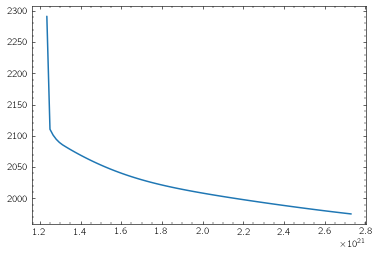

In [38]:
m = np.array([item[0][0] for item in res.clouds_MC])
v = np.array([item[0][1] for item in res.clouds_MC])
n = np.array([item[0][2] for item in res.clouds_MC])
Z = np.array([item[0][3] for item in res.clouds_MC])
r = res.cloud_r
plt.plot(r[:98],m[:98]/Msun)

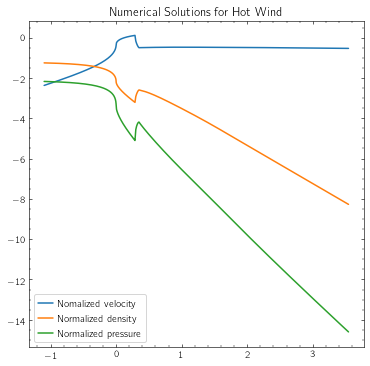

In [39]:
res.plot_wind()

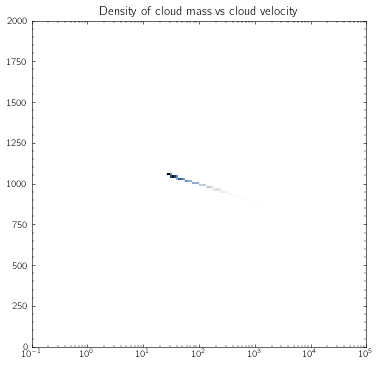

In [25]:
steps = len(res.clouds)-1
#steps = 50
res.plot_density(steps, res, cloud)

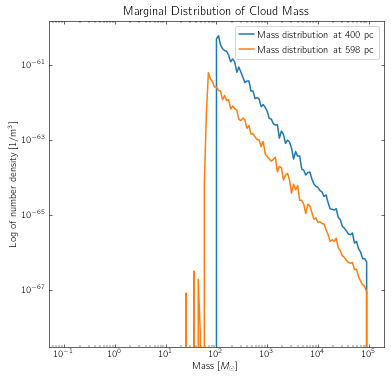

In [26]:
res.plot_mass_MC([0,99],cloud, True)

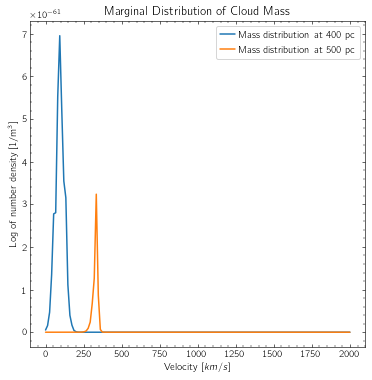

In [43]:
res.plot_velocity_MC([0,100],cloud, False)

In [235]:
res.plot_scatter(10, res, cloud)

IndexError: list index out of range

In [ ]:
x=res.integrateNFlux([0,steps],cloud)
x,x[1]/x[0]

In [ ]:
res.plot_wind()

In [236]:
res.plot_cloud([50], cloud)

IndexError: list index out of range

<Figure size 432x432 with 0 Axes>

In [237]:
res.plot_mass([0,steps-1], cloud)

IndexError: list index out of range

<Figure size 432x432 with 0 Axes>

In [238]:
res.plot_velocity([0,steps], cloud)


IndexError: list index out of range

<Figure size 432x432 with 0 Axes>

In [239]:
res.plot_cloud([steps], cloud)

IndexError: list index out of range

<Figure size 432x432 with 0 Axes>

In [240]:
res.plot_cloud([1], cloud)

IndexError: list index out of range

<Figure size 432x432 with 0 Axes>

In [ ]:
filename = "phase_space.csv"
f = res.cloud_f[1]
res.save_grid(filename,f, cloud)

In [ ]:
filename = "cloud_mass.csv"
f = cloud.M_cloud
res.save_grid(filename, f, cloud)

In [ ]:
filename = "Mdot_over_v.csv"
f = cloud.Mdot_over_v
res.save_grid(filename, f, cloud)

In [ ]:
filename = "vdot_over_v.csv"
f = cloud.vdot_over_v
res.save_grid(filename, f, cloud)

In [ ]:
filename = "M_left.csv"
f = cloud.m_left
res.save_grid(filename, f, cloud)

In [ ]:
filename = "M_right.csv"
f = cloud.m_right
res.save_grid(filename, f, cloud)

In [ ]:
filename = "CFL_m0.csv"
f = control.cfl_m0[0]
res.save_grid(filename, f, cloud)

In [ ]:
filename = "CFL_m1.csv"
f = control.cfl_m1[0]
res.save_grid(filename, f, cloud)

In [ ]:
filename = "CFL_v0.csv"
f = control.cfl_v0[0]
res.save_grid(filename, f, cloud)

In [ ]:
filename = "CFL_v1.csv"
f = control.cfl_v1[0]
res.save_grid(filename, f, cloud)

In [ ]:
const = Const()
pm = Param("Inputs", const).paramDict
control = EvolveControl(const, pm)


res = Result(const, pm)
wind = Wind(control, const, pm, res)
cloud = CloudMC(wind, control, const, pm, res)
# cloud = Cloud(wind, control, const, pm, res)


In [ ]:
rhoz = res.wind_rhoz
r = res.wind_r
rhoz[0]
res.wind_rhoz[-1], res.wind_rho[-1]

In [ ]:
plt.plot(r,rhoz)

In [ ]:
pm['CLOUD_METALLICITY']

In [ ]:
pm['V_MU']

In [ ]:
wind.metallicity

In [ ]:
res.wind_rho_dot[400], res.wind_p_dot[0], res.wind_epsilon_dot[0]

In [ ]:
res.wind_rho[-1]

In [ ]:
res.wind_P[-1]

In [ ]:
res.clouds[-1]

In [ ]:
sum(res.clouds[10][:,1] * res.clouds[10][:,2])

In [ ]:
sum(res.clouds[10][:,1] * res.clouds[10][:,2])

In [ ]:
sum(res.clouds[-1][:,1] * res.clouds[-1][:,2])

In [ ]:
res.clouds[0][:1][0]

In [ ]:
a = res.clouds[1600][:,0]/const.Msun
min(a)

In [350]:
cloud.retiredCloud

AttributeError: 'Cloud' object has no attribute 'retiredCloud'

In [391]:
min(abs(cloud.dr_M / const.pc))

13.78638070975747

In [392]:
min(abs(cloud.dr_v / const.pc))

4.275299220118284

In [432]:
len(res.clouds)

161

In [51]:
def getCloudSource(dot_params, wind_params, cloud_params, aux_params):        
    Mdot_grow, Mdot_loss = dot_params
    P, v, rho = wind_params
    M_cloud, v_cloud, N_cloud, rho_cloud = cloud_params     
    dr, dvol, gamma, retire_mass, retire_flag = aux_params

    dt = dr/v_cloud
    Mdot_grow = np.where(M_cloud < retire_mass, 0, Mdot_grow)
    Mdot_loss = np.where(M_cloud < retire_mass, M_cloud/dt, Mdot_loss)

    n_cloud = N_cloud/dvol
    rhodot = (Mdot_grow + Mdot_loss) * n_cloud
    pdot = (v * Mdot_grow + v_cloud * Mdot_loss) * n_cloud
    vB_2 = 0.5 * v**2 + gamma / (gamma - 1) * P / rho   # leave out escape velocity
    vB_cloud_2 = 0.5 * v_cloud**2 + gamma / (gamma - 1) * P / rho_cloud
    epsilondot = (vB_2 * Mdot_grow + vB_cloud_2 * Mdot_loss) * n_cloud                
    return rhodot, pdot, epsilondot    

In [50]:
res.wind_rho_dot

array([ 2.26135874e-38, -3.12207697e-39, -2.93671189e-39, -3.24984829e-39,
       -3.05592995e-39, -2.82857859e-39, -2.60184408e-39, -2.38924797e-39,
       -2.19460274e-39, -2.01808725e-39, -1.85855625e-39, -1.71445382e-39,
       -1.58417804e-39, -1.46622371e-39, -1.35923035e-39, -1.26199048e-39,
       -1.17344109e-39, -1.09264957e-39, -1.01879811e-39, -9.51168909e-40,
       -8.89130878e-40, -8.32127948e-40, -7.79668937e-40, -7.31318933e-40,
       -6.86691909e-40, -6.45444393e-40, -6.07270045e-40, -5.71895040e-40,
       -5.39074094e-40, -5.08587029e-40, -4.80235821e-40, -4.53842031e-40,
       -4.29244586e-40, -4.06297835e-40, -3.84869858e-40, -3.64840986e-40,
       -3.46102497e-40, -3.28555472e-40, -3.12109789e-40, -2.96683226e-40,
       -2.82200671e-40, -2.68593432e-40, -2.55798606e-40, -2.43758521e-40,
       -2.32420242e-40, -2.21735134e-40, -2.11658458e-40, -2.02149021e-40,
       -1.93168860e-40, -1.84682949e-40, -1.76658941e-40, -1.69066941e-40,
       -1.61879288e-40, -

In [191]:
const = Const()
pm = Param("Inputs", const).paramDict
control = EvolveControl(const, pm)
res = Result(const, pm)
wind = Wind(control, const, pm, res)
cloud = Cloud(wind, control, const, pm, res) 
(Mdot,vdot,Mdot_grow,Mdot_loss,rho_clouds)= Utils.dot_cloud_calc(wind.P, wind.v, wind.rho, cloud.M_cloud, cloud.v_cloud, pm)
r_curr, r_next, dr, dvol = control.get_cloudr_info()

In [205]:
dot_params = (Mdot_grow, Mdot_loss)
wind_params = (wind.P, wind.v, wind.rho)
cloud_params = (cloud.M_cloud, cloud.v_cloud, cloud.f, rho_clouds)
aux_params = (dr, dvol, gamma, cloud.retire_mass, cloud.retire_flag)  

In [206]:
Mdot_grow, Mdot_loss = dot_params
P, v, rho = wind_params
M_cloud, v_cloud, N_cloud, rho_cloud = cloud_params     
dr, dvol, gamma, retire_mass, retire_flag = aux_params
dt = dr/v_cloud
Mdot_grow = np.where(M_cloud < retire_mass, 0, Mdot_grow)
Mdot_loss = np.where(M_cloud < retire_mass, M_cloud/dt, Mdot_loss)
n_cloud = N_cloud/dvol
rhodot = (Mdot_grow + Mdot_loss) * n_cloud
pdot = (v * Mdot_grow + v_cloud * Mdot_loss) * n_cloud
vB_2 = 0.5 * v**2 + gamma / (gamma - 1) * P / rho   # leave out escape velocity
vB_cloud_2 = 0.5 * v_cloud**2 + gamma / (gamma - 1) * P / rho_cloud
epsilondot = (vB_2 * Mdot_grow + vB_cloud_2 * Mdot_loss) * n_cloud    

In [207]:
sum(rhodot*cloud.integrateDelta), sum(pdot*cloud.integrateDelta), sum(epsilondot*cloud.integrateDelta)

(-2.2613587382326457e-38, 2.0692637920846305e-29, 4.136956301974086e-21)

In [208]:
n_cloud = cloud.f / dvol        
rhodot_grow = Mdot_grow * n_cloud
rhodot_loss = Mdot_loss * n_cloud
rhodot = rhodot_grow + rhodot_loss
pdot = (v * Mdot_grow + cloud.v_cloud * Mdot_loss) * n_cloud
vB_2 = 0.5 * v**2 + cloud.gamma / (cloud.gamma - 1) * P / rho   # leave out escape velocity
vB_cloud_2 = 0.5 * cloud.v_cloud**2 + cloud.gamma / (cloud.gamma - 1) * P / rho_cloud
epsilondot = (vB_2 * Mdot_grow + vB_cloud_2 * Mdot_loss) * n_cloud

In [209]:
sum(rhodot*cloud.integrateDelta), sum(pdot*cloud.integrateDelta), sum(epsilondot*cloud.integrateDelta)

(-2.2613587382326457e-38, 2.0692637920846305e-29, 4.136956301974086e-21)

In [138]:
cloud.f

array([0., 0., 0., ..., 0., 0., 0.])

In [139]:
cloud.f_last

array([1.18579704e-14, 1.51653309e-14, 1.93400722e-14, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [167]:
retire_mass

2e+33

In [168]:
const.Msun

2e+33

In [438]:
def gen_powerlaw1(nbsample, xmin, xmax, power, unit):
    logr = (xmax-xmin) * np.random.random(size=nbsample) + xmin
    r = 10**logr * unit
    b = 10**xmax * unit
    a = 10**xmin * unit
    power += 1
    n = power * r**(power-1) / (b**power - a**power) 
    return r, n  

In [439]:
gen_powerlaw1(10, -1, 3, -2, const.Msun)

(array([1.14291188e+35, 3.80831292e+33, 1.06575440e+34, 2.61011932e+34,
        5.02288912e+33, 4.35904363e+34, 1.50254487e+35, 3.66448664e+33,
        1.21148214e+35, 1.21559332e+35]),
 array([1.53125646e-38, 1.37913943e-35, 1.76099920e-36, 2.93597738e-37,
        7.92804752e-36, 1.05266697e-37, 8.85969001e-39, 1.48952276e-35,
        1.36282282e-38, 1.35362018e-38]))

In [61]:
res.cloud_r

array([1.38870000e+21, 1.38870020e+21, 1.38870075e+21, ...,
       1.63022229e+21, 1.63054424e+21, 1.63086633e+21])

In [42]:
i = 1

def plot_contour(i):
    _, v, rho, P, _ = res.post_wind_info[i-1]
    #wind_offset = res.Pvrho_start + 500
    #P = res.wind_P[wind_offset]
    #rho=res.wind_rho[wind_offset]
    #v = res.wind_v[wind_offset]

    v_bins = cloud.vbndry
    M_bins = cloud.mbndry
    clouds = res.clouds[i]

    nbs_vbin= len(v_bins)
    nbs_Mbin= len(M_bins)

    M_cloud = np.tile(M_bins, nbs_vbin)
    v_cloud = np.repeat(v_bins, nbs_Mbin)

    (mdot,vdot,_,_,_) = Utils.dot_cloud_calc(P, v, rho, M_cloud, v_cloud, pm)
    vdot = vdot / v_cloud
    mdot2D = np.reshape(mdot,(nbs_vbin, nbs_Mbin))
    vdot2D = np.reshape(vdot,(nbs_vbin, nbs_Mbin))

    f=np.reshape(np.zeros(nbs_vbin * nbs_Mbin),(nbs_vbin,nbs_Mbin))
    v_min = v_bins[0]
    v_max = v_bins[nbs_vbin-1]
    M_min = M_bins[0]
    M_max = M_bins[nbs_Mbin-1]
    for item in clouds:
        if (item[1]>=v_min) and (item[1]<=v_max) and (item[0]>=M_min) and (item[0]<=M_max):
            v_idx = np.max(np.where(v_bins <= item[1]))
            M_idx = np.max(np.where(M_bins <= item[0]))
            f[v_idx][M_idx]+=item[2]

    f, M_bins, v_bins = Utils.binnings_MC(i, res, cloud)


    fig,ax=plt.subplots(1,1,constrained_layout=True)
    colormap_r = ListedColormap(cmr.rainforest.colors[::-1])
    plot = plt.pcolormesh(M_bins/const.Msun, v_bins/const.km, np.abs(f), ### HERE IS WHERE I PLOT THE MASS DISTRIBUTIO
        norm=colors.LogNorm(), #color limits
        cmap=colormap_r) #color map
    cb = fig.colorbar(plot, ax=ax, location="right")
    cb.set_label(r'$\frac{d^2 N_{cl}}{d \log M_{cl} d \log v_{cl}}$') ### PUT YOUR LABEL HERE
    cb.ax.minorticks_off()
    contour = ax.contourf(M_bins/const.Msun,v_bins/const.km, vdot2D, cmap=cmr.iceburn, norm=colors.LogNorm(), alpha=0.5)
    cb = fig.colorbar(contour, ax=ax, location="top")
    cb.set_ticklabels([r"$\frac{1}{256}$",r"$\frac{1}{16}$",r"$1$",r"$16$",r"$256$",r"$2^{12}$"])
    cb.set_label(r'$c_s t_{\rm cool} / L$')
    #plt.figure(figsize=(6,6))
    #plt.pcolormesh(M_bins/const.Msun,v_bins/const.km, np.abs(f),cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)
    plt.xscale('log')
    plt.title("Density of cloud mass vs cloud velocity")  
    return

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Log scale: values of z <= 0 have been masked


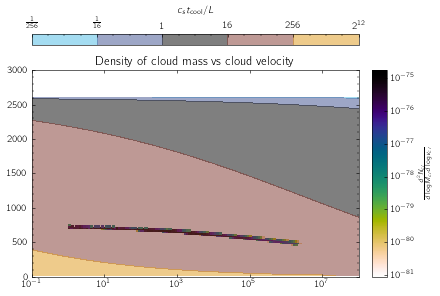

In [44]:
plot_contour(700)

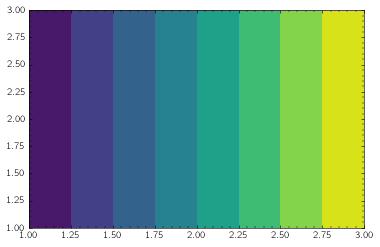

In [84]:
testv=[1,2,3]
testm=[1,2,3]
plt.contourf(testv, testm, testf)


In [290]:
epsilon = 1e-5

def supersonic(r,z):
    return z[0]/np.sqrt(gamma*z[2]/z[1]) - (1.0 + epsilon)

supersonic.terminal = True

def subsonic(r,z):
    return z[0]/np.sqrt(gamma*z[2]/z[1]) - (1.0 - epsilon)

subsonic.terminal = True

def cold_wind(r,z):
    return np.sqrt(gamma*z[2]/z[1])/np.sqrt(gamma*kb*T_cloud/(mu*mp)) - (1.0 + epsilon)

cold_wind.terminal = True


def cloud_stop(r,z):
    return z[5] - 10e5

cloud_stop.terminal = True

def Wind_Evo(r, state):
    v_wind     = state[0]
    rho_wind   = state[1]
    Pressure   = state[2]
    rhoZ_wind  = state[3]
    M_cloud    = state[4]
    v_cloud    = state[5]
    Z_cloud    = state[6]

    # wind properties
    cs_sq_wind   = (gamma*Pressure/rho_wind)
    Mach_sq_wind = (v_wind**2 / cs_sq_wind)
    Z_wind       = rhoZ_wind/rho_wind
    vc           = v_circ0 * np.where(r<r0, r/r0, 1.0)
    Phir         = v_circ0**2 * np.where(r<r0, 0.5 * (r/r0)**2, np.log(r/r0)) 
    # vc           = v_circ0 * np.where(r<r0, (r/r0)**2, 1.0)
    # Phir         = v_circ0**2 * np.where(r<r0, (1/3.) * (r/r0)**3, np.log(r)) 
    vBsq_wind    = 0.5 * v_wind**2 + (gamma / (gamma-1)) * Pressure/rho_wind + Phir

    
    # source term from inside galaxy
    Edot_SN = Edot_per_Vol * np.where(Mach_sq_wind<1, 1.0, 0.0) #* np.where(r<r0, 1.0, 0.0)
    Mdot_SN = Mdot_per_Vol * np.where(Mach_sq_wind<1, 1.0, 0.0) #* np.where(r<r0, 1.0, 0.0)

    # cloud properties
    Ndot_cloud              = Ndot_cloud0 * np.where(r<cold_cloud_injection_radial_extent, (r/cold_cloud_injection_radial_extent)**cold_cloud_injection_radial_power, 1.0)
    number_density_cloud    = Ndot_cloud/(Omwind * v_cloud * r**2)
    cs_cl_sq                = gamma * kb*T_cloud/(mu*mp)
    vBsq_cl                 = 0.5 * v_cloud**2 + (1 / (gamma-1)) * cs_cl_sq + Phir
#    print(number_density_cloud)
    # cloud transfer rates
    rho_cloud    = Pressure * (mu*mp) / (kb*T_cloud) # cloud in pressure equilibrium
    chi          = rho_cloud / rho_wind
    r_cloud      = (M_cloud / ( 4*np.pi/3. * rho_cloud))**(1/3.) 
    v_rel        = (v_wind-v_cloud)
    v_turb       = f_turb0 * v_rel * chi**TurbulentVelocityChiPower
    T_wind       = Pressure/kb * (mu*mp/rho_wind)
    T_mix        = (T_wind*T_cloud)**0.5
    Z_mix        = (Z_wind*Z_cloud)**0.5
    t_cool_layer = tcool_P(T_mix, Pressure/kb, Z_mix/Z_solar)[()] 
    t_cool_layer = np.where(t_cool_layer<0, 1e10*Myr, t_cool_layer)
    ksi          = r_cloud / (v_turb * t_cool_layer)
    AreaBoost    = geometric_factor * chi**CoolingAreaChiPower
    v_turb_cold  = v_turb * chi**ColdTurbulenceChiPower
    Mdot_grow    = Mdot_coefficient * 3.0 * M_cloud * v_turb * AreaBoost / (r_cloud * chi) * np.where( ksi < 1, ksi**0.5, ksi**0.25 )
    Mdot_loss    = Mdot_coefficient * 3.0 * M_cloud * v_turb_cold / r_cloud 
    Mdot_cloud   = np.where(M_cloud > M_cloud_min, Mdot_grow - Mdot_loss, 0)
    
    
    # density
    drhodt       = (number_density_cloud * Mdot_cloud)
    drhodt_plus  = (number_density_cloud * Mdot_loss)
    drhodt_minus = (number_density_cloud * Mdot_grow) 

    
    # momentum
    p_dot_drag   = 0.5 * drag_coeff * rho_wind * np.pi * v_rel**2 * r_cloud**2 * np.where(M_cloud>M_cloud_min, 1, 0)
    dpdt_drag    = (number_density_cloud * p_dot_drag)
    
    # energy
    e_dot_cool   = 0.0 if (Cooling_Factor==0) else (rho_wind/(muH*mp))**2 * Lambda_P_rho((Pressure,rho_wind))
    # metallicity
    drhoZdt         = -1.0 * (number_density_cloud * (Z_wind*Mdot_grow + Z_cloud*Mdot_loss)) ############## sign #############

    # wind gradients
    # velocity
    dv_dr       = 2/Mach_sq_wind
    dv_dr      += - (vc/v_wind)**2
    dv_dr      +=  drhodt_minus/(rho_wind*v_wind/r) * (1/Mach_sq_wind)
    dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * (1/Mach_sq_wind)
    dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * v_rel/v_wind
    dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * (gamma-1)/2.*(v_rel/v_wind)**2
    dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * (-(cs_sq_wind - cs_cl_sq)/v_wind**2)
    dv_dr      += (gamma-1)*e_dot_cool/(rho_wind*v_wind**3/r)
    dv_dr      += -(gamma-1)*dpdt_drag*v_rel/(rho_wind*v_wind**3/r)
    dv_dr      += -dpdt_drag/(rho_wind*v_wind**2/r)
    dv_dr      *= (v_wind/r)/(1.0-(1.0/Mach_sq_wind))
    
    # density
    drho_dr       = -2
    drho_dr      += (vc/v_wind)**2
    drho_dr      += -drhodt_minus/(rho_wind*v_wind/r)
    drho_dr      += drhodt_plus/(rho_wind*v_wind/r)
    drho_dr      += drhodt_plus/(rho_wind*v_wind/r) * v_rel/v_wind
    drho_dr      += drhodt_plus/(rho_wind*v_wind/r) * (gamma-1)/2.*(v_rel/v_wind)**2
    drho_dr      += drhodt_plus/(rho_wind*v_wind/r) * (-(cs_sq_wind - cs_cl_sq)/v_wind**2)
    drho_dr      += -(gamma-1)*e_dot_cool/(rho_wind*v_wind**3/r)
    drho_dr      += (gamma-1)*dpdt_drag*v_rel/(rho_wind*v_wind**3/r)
    drho_dr      += dpdt_drag/(rho_wind*v_wind**2/r)
    drho_dr      *= (rho_wind/r)/(1.0-(1.0/Mach_sq_wind))

    # pressure
    dP_dr       = -2
    dP_dr      += (vc/v_wind)**2
    dP_dr      += -drhodt_minus/(rho_wind*v_wind/r)
    dP_dr      += drhodt_plus/(rho_wind*v_wind/r)
    dP_dr      += drhodt_plus/(rho_wind*v_wind/r) * v_rel/v_wind
    dP_dr      += drhodt_plus/(rho_wind*v_wind/r) * (gamma-1)/2.* (v_rel**2 / cs_sq_wind)
    dP_dr      += drhodt_plus/(rho_wind*v_wind/r) * (-(cs_sq_wind - cs_cl_sq)/cs_sq_wind)
    dP_dr      += -(gamma-1)*e_dot_cool/(rho_wind*v_wind*cs_sq_wind/r)
    dP_dr      += (gamma-1)*dpdt_drag*v_rel/(rho_wind*v_wind*cs_sq_wind/r)
    dP_dr      += dpdt_drag/(rho_wind*v_wind**2/r)
    dP_dr      *= (Pressure/r)*gamma/(1.0-(1.0/Mach_sq_wind))


    drhoZ_dr   = drho_dr*(rhoZ_wind/rho_wind) + (rhoZ_wind/r) * drhodt_plus/(rho_wind*v_wind/r) * (Z_cloud/Z_wind - 1)

    # cloud gradients
    dM_cloud_dr = Mdot_cloud/v_cloud

    dv_cloud_dr = (p_dot_drag + v_rel*Mdot_grow - M_cloud * vc**2/r) / (M_cloud * v_cloud) * np.where(M_cloud>M_cloud_min, 1, 0)

#    print(p_dot_drag, v_rel, vc**2)
#
    
    dZ_cloud_dr = (Z_wind-Z_cloud) * Mdot_grow / (M_cloud * v_cloud) * np.where(M_cloud>M_cloud_min, 1, 0)

    return np.r_[dv_dr, drho_dr, dP_dr, drhoZ_dr, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr]


In [291]:
def dot_cloud_calc(wind, cloud, tcool_P, pm):   
    # cloud transfer rates
    T_cloud = pm['CLOUD_TEMP']
    f_turb0 = pm['F_TURB0']
    TurbulentVelocityChiPower = pm['TURBULENT_VELOCITY_CHI_POWER'] 
    geometric_factor  = pm['GEOMETRIC_FACTOR']
    CoolingAreaChiPower  = pm['COOLING_AREA_CHI_POWER']
    ColdTurbulenceChiPower = pm['COLD_TURBULENCE_CHI_POWER'] 
    Mdot_coefficient = pm['MDOT_COEFFICIENT']
    drag_coeff = pm['DRAG_COEFF']
    vc = pm['V_CIR']
    M_cloud_min = pm['M_CLOUD_MIN']
    retire_mass = pm['RETIREMENT_MASS']

    Pressure = wind['P']
    v_wind = wind['v']
    rho_wind = wind['rho']
    rhoz_wind = wind['rhoZ']

    M_cloud = cloud['M']
    v_cloud = cloud['v']
    Z_cloud = cloud['Z']
    Z_wind = rhoz_wind / rho_wind
    rho_cloud    = Pressure * (mu*mp) / (kb*T_cloud) + [0]*M_cloud # cloud in pressure equilibrium
    chi          = rho_cloud / rho_wind
    r_cloud      = (M_cloud / ( 4*np.pi/3. * rho_cloud))**(1/3.) 
    v_rel        = (v_wind-v_cloud)
    v_turb0       = f_turb0 * v_rel * chi**TurbulentVelocityChiPower
    v_turb       = np.where(v_turb0 <=0, 0.001, v_turb0)
    T_wind       = Pressure/kb * (mu*mp/rho_wind)
    T_mix        = (T_wind*T_cloud)**0.5
    Z_mix        = (Z_wind*Z_cloud)**0.5
    t_cool_layer = tcool_P(T_mix, Pressure/kb, Z_mix/const.ZSun)[()] 
    t_cool_layer = np.where(t_cool_layer<0, 1e10*Myr, t_cool_layer)
#        t_cool_layer = 1*Myr
    ksi          = r_cloud / (v_turb * t_cool_layer)
    AreaBoost    = geometric_factor * chi**CoolingAreaChiPower
    v_turb_cold  = v_turb * chi**ColdTurbulenceChiPower
    Mdot_grow    = Mdot_coefficient * 3.0 * M_cloud * v_turb * AreaBoost / (r_cloud * chi) * np.where( ksi < 1, ksi**0.5, ksi**0.25 )
    Mdot_loss    = Mdot_coefficient * 3.0 * M_cloud * v_turb_cold / r_cloud 
    Mdot_cloud   = np.where(M_cloud > M_cloud_min, Mdot_grow - Mdot_loss, 0)        
    return Mdot_grow, Mdot_loss, rho_cloud, r_cloud   


In [292]:
r_curr = 1.2276036480431476e+21
v_wind = 248610506.6416017
rho_wind = 2.694062712769019e-26
P_wind = 2.051510020042152e-10
rhoZ_wind = 1.077625085107609e-27
M_cloud = 1.73956501e+36
v_cloud = 35007096.61635489
n_cloud = 1.9132472e-61
Z_cloud = 0.04002113

r_curr = control.r_wind
v_wind = wind.state['v']
rho_wind = wind.state['rho']
P_wind = wind.state['P']
rhoZ_wind = wind.state['rhoZ']
M_cloud = cloud.live['M']
v_cloud = cloud.live['v']
n_cloud = cloud.live['n']
Z_cloud = cloud.live['Z']
print(r_curr, v_wind, rho_wind, P_wind, rhoZ_wind, M_cloud, v_cloud, n_cloud, Z_cloud)





#{'M': array([1.85834842e+33]), 'v': array([65005163.28693969]), 'n': array([5.06263386e-64]), 'Z': array([8592.95271681])}
#{'v': 142204176.69805276, 'rho': 7.373568468544022e-28, 'P': 3.353927789567221e-13, 'rhoZ': 4.862298959986806e-27}

r0 = 300 * pc
state = np.r_[v_wind, rho_wind, P_wind, rhoZ_wind, M_cloud, v_cloud, Z_cloud]
v_circ0 = pm['V_CIR']
Edot_per_Vol = wind.Edot_per_Vol
Mdot_per_Vol = wind.Mdot_per_Vol

Ndot_cloud0 = 1.2683916793505837e-10
cold_cloud_injection_radial_extent = 399 * pc
cold_cloud_injection_radial_power = 0
Omwind = 4 * np.pi

T_cloud = pm['CLOUD_TEMP']
f_turb0 = pm['F_TURB0']
TurbulentVelocityChiPower = pm['TURBULENT_VELOCITY_CHI_POWER']
tcool_P = Cooling('Lambda_tab_redshifts.npz',const).tcool_P
Z_solar = const.ZSun
geometric_factor = pm['GEOMETRIC_FACTOR']
CoolingAreaChiPower = pm['COOLING_AREA_CHI_POWER']
ColdTurbulenceChiPower = pm['COLD_TURBULENCE_CHI_POWER']
Mdot_coefficient = pm['MDOT_COEFFICIENT']
M_cloud_min = pm['M_CLOUD_MIN']
drag_coeff = pm['DRAG_COEFF']
Cooling_Factor = 0
CFL_MC = pm['CFL_MC']

1.231314e+21 248969919.52298003 2.673985245725589e-26 2.0260919533594782e-10 1.0695940982902364e-27 [1.34678841e+36] [63190250.86962456] [8.56971084e-63] [0.02447923]


In [293]:
Wind_Evo(r_curr, state)

array([-8.14691146e-15, -3.66673112e-47, -4.69063073e-31, -1.63643339e-48,
       -2.20297790e+14,  2.45388997e-14,  2.17456011e-24])

In [34]:
windinfo = Utils.write_wind(np.array([v_wind]), np.array([rho_wind]), np.array([P_wind]), np.array([rhoZ_wind]))
cloudinfo = Utils.write_cloud(np.array([M_cloud]), np.array([v_cloud]), np.array([n_cloud]), np.array([Z_cloud]))

(Mdot_grow, Mdot_loss, rho_clouds, r_clouds) = Utils.dot_cloud_calc(windinfo, cloudinfo, tcool_P, pm) 
control.delta_r = Utils.getdr_MC(cloud.CFL_MC, cloudinfo, Mdot_grow, Mdot_loss)
r_curr, r_next, dr = control.get_cloud_r_info()                
(Mdot, vdot, Zdot, pdot_drag) = Utils.get_Mdot_vdot_Zdot(r_curr, Mdot_grow, Mdot_loss, windinfo, cloudinfo, pm)
transfer.update_cloud(Mdot_grow, Mdot_loss, cloudinfo, cloud.retire)
cloud_next = cloud.evolve(dr, r_curr, r_next, cloudinfo, Mdot, vdot, Zdot)


In [35]:
Mdot/v_cloud, vdot/v_cloud

(array([[-8.94209154e+14]]), array([[2.93736663e-15]]))

In [248]:
r = r_curr 
rho_cloud, r_cloud, pdot_drag = Utils.get_cloud_rho_r_pdotdrag(windinfo, cloudinfo, const, pm)
M_cloud_min = pm['M_CLOUD_MIN']
v_wind = windinfo['v']
rho_wind = windinfo['rho']
rhoZ_wind = windinfo['rhoZ']
M_cloud = cloudinfo['M']
v_cloud = cloudinfo['v']
Z_cloud = cloudinfo['Z']
(vc_sqr, _, _) = Utils.get_vcir2_Phi_vesc2(r, pm)
Mdot = (Mdot_grow - Mdot_loss)
v_rel = v_wind - v_cloud
vdot = (pdot_drag + v_rel*Mdot_grow - M_cloud * vc_sqr/r) / M_cloud * np.where(M_cloud>M_cloud_min, 1, 0)
Z_wind = rhoZ_wind / rho_wind
Mdot_Z = Z_wind * Mdot_grow + Z_cloud * Mdot_loss
Zdot = (Mdot_Z - Z_cloud * Mdot)/M_cloud
Mdot/v_cloud, vdot/v_cloud, Zdot, pdot_drag

(array([[-8.94209154e+14]]),
 array([[-1.5974878e-15]]),
 array([[1.67332024e-15]]),
 array([[1.92341559e+29]]))

In [99]:
(pdot_drag + v_rel * Mdot_grow - M_cloud * vc_sqr/r) / M_cloud /v_cloud
v_cloud / km

array([[384.14571367]])

In [364]:


cloud_live, cloud_retire = Utils.retireCloud(cloud_next, pm)
live = Utils.ntuple2array(cloud_live)
retire = Utils.ntuple2array(cloud_retire)
#self.live['M']=live[0]
#self.live['v']=live[1]
#self.live['n']=live[2]
#self.live['Z']=live[3]
#self.retire['M']=retire[0]
#self.retire['v']=retire[1]
#self.retire['n']=retire[2]
#self.retire['Z']=retire[3]

cloud_next
cloud_live

array([], dtype=float64)

In [108]:
pm['SFR']*0.2/(4*np.pi*r**2)/v_cloud / M_cloud

array([[1.8460745e-61]])

In [637]:
def supersonic(r,z):
    return z[0]/np.sqrt(gamma*z[2]/z[1]) - (1.0 + epsilon)

supersonic.terminal = True

def subsonic(r,z):
    return z[0]/np.sqrt(gamma*z[2]/z[1]) - (1.0 - epsilon)

subsonic.terminal = True

def cold_wind(r,z):
    return np.sqrt(gamma*z[2]/z[1])/np.sqrt(gamma*kb*T_cloud/(mu*mp)) - (1.0 + epsilon)

cold_wind.terminal = True


def cloud_stop(r,z):
    return z[5] - 10e5

cloud_stop.terminal = True

def calc_wind_source(Phir, wind, cloud, rho_cloud, r_cloud, p_dot_drag, Mdot_grow, Mdot_loss):
    v = wind['v']
    rho = wind['rho']
    P = wind['P']
    rhoz = wind['rhoZ']
    M_cloud = cloud['M']
    v_cloud = cloud['v']
    n_cloud = cloud['n']
    Z_cloud = cloud['Z']

    Z_wind = rhoz / rho
    dpdt_drag    = (n_cloud * p_dot_drag)        
    rho_dot_plus = Mdot_loss * n_cloud
    rho_dot_minus = Mdot_grow * n_cloud
    rho_dot = rho_dot_plus - rho_dot_minus
    p_dot = rho_dot_plus*v_cloud - rho_dot_minus*v - dpdt_drag
    vB_2 = 0.5 * v**2 + gamma / (gamma - 1) * P / rho + Phir
    vB_cloud_2 = 0.5 * v_cloud**2 + gamma / (gamma - 1) * P / rho_cloud + Phir
    epsilon_dot = rho_dot_plus * vB_cloud_2 - rho_dot_minus * vB_2 - dpdt_drag * v_cloud
    rhoz_dot = Z_cloud * rho_dot_plus - Z_wind * rho_dot_minus   
#    print(Phir, wind, cloud, rho_cloud, r_cloud, p_dot_drag, Mdot_grow, Mdot_loss)
    if dump_source_test == 1: print(rho_dot, p_dot, epsilon_dot, rhoz_dot)
    return rho_dot, p_dot, epsilon_dot, rhoz_dot 

def evolve(r, z):
    v,rho,P, rhoz, M_cloud, v_cloud, Z_cloud= z
    a = dot_info(r, z) 
    dv_dr = a[0]
    drho_dr = a[1]
    dP_dr = a[2]
    drhoz_dr = a[3]
    dM_cloud_dr = a[4]
    dv_cloud_dr = a[5]
    dZ_cloud_dr = a[6]
    return [dv_dr, drho_dr, dP_dr, drhoz_dr, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr] 

def dot_info(r, states):
    
    r0 = pm['SONIC_POINT']
    r1 = pm['R_START']
    gamma = pm['GAMMA']
    Mdot = pm['MDOT']
    Edot = pm['EDOT']
    SFR = pm['SFR']
    M0 = 10**pm['M_MU'] * const.Msun
    v0 = pm['V_MU'] * const.km    
    cold_cloud_injection_radial_extent = 399 * pc
    cold_cloud_injection_radial_power = np.inf
    
    
    
    v_wind, rho_wind, P_wind, rhoZ_wind, M_cloud, v_cloud, Z_cloud = states 
    if dump_wind_test == 1: print('WIND_TEST', r/pc, v_wind, rho_wind, P_wind, rhoZ_wind)  
    
  

    
    n_cloud = SFR*0.2 / (1000  * Msun) / (4 * np.pi *r**2 * v_cloud)  
    wind0 = {'v': v_wind, 'rho': rho_wind, 'P': P_wind, 'rhoZ': rhoZ_wind}
    cloud0 = {'M': M_cloud, 'v': v_cloud, 'n': n_cloud, 'Z': Z_cloud}

    if dump_cloud_test == 1: print('CLOUD_TEST', round(r/pc), M_cloud, v_cloud, n_cloud, Z_cloud)
    
    Vol = 4/3 * np.pi * r0**3         
    Mdot_per_Vol = Mdot / Vol    
    Edot_per_Vol = Edot / Vol

    cs_sqr = gamma * P_wind / rho_wind
    mach_sqr = v_wind**2 / cs_sqr
    
    vc_sqr, Phir, vesc_sqr = Utils.get_vcir2_Phi_vesc2(r, pm)
    
    
    (Mdot_grow, Mdot_loss, rho_cloud, r_cloud) = Utils.dot_cloud_calc(wind0, cloud0, tcool_P, pm)     

    
    (Mdot, vdot, Zdot, pdot_drag) = Utils.get_Mdot_vdot_Zdot(r, Mdot_grow, Mdot_loss, wind0, cloud0, pm)
    
    
    rho_dot, p_dot, e_dot, rhoz_dot = calc_wind_source(Phir, wind0, cloud0, rho_cloud, r_cloud, pdot_drag, Mdot_grow, Mdot_loss)
    
    
    
    dv_dr  = 2/mach_sqr
    dv_dr += -vc_sqr/v_wind**2
    dv_dr += -rho_dot/(rho_wind*v_wind/r) * (gamma+1)*0.5
    dv_dr += 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
    dv_dr += -1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
    dv_dr += - rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
    dv_dr *= (v_wind/r) * (1/(1-1/mach_sqr))    


    drho_dr  = -2
    drho_dr += vc_sqr/v_wind**2
    drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma+3)*0.5
    drho_dr -= 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
    drho_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
    drho_dr -= rho_dot/(rho_wind*v_wind/r) * 1/mach_sqr
    drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
    drho_dr *= (rho_wind/r) * (1/(1-1/mach_sqr))

    dP_dr  = -2
    dP_dr += vc_sqr/v_wind**2
    dP_dr += rho_dot/(rho_wind*v_wind/r)
    dP_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*mach_sqr*(1+vesc_sqr/v_wind**2)
    dP_dr -= 1/(rho_wind*v_wind/r)  * p_dot/v_wind
    dP_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*mach_sqr*(e_dot-p_dot*v_wind)/v_wind**2
    dP_dr *= (P_wind/r) * (gamma/(1-1/mach_sqr))
    
    
    
    Z_wind = rhoZ_wind / rho_wind
    
#    drhoZ_dr = Z_wind * drho_dr + rhoz_dot / v - Z_wind * rho_dot /v
    drhoZ_dr = Z_wind * drho_dr + rhoz_dot / v_wind - Z_wind * rho_dot /v_wind
    
    
    
    dM_cloud_dr = Mdot/v_cloud
    dv_cloud_dr = vdot/v_cloud   
    dZ_cloud_dr = Zdot/v_cloud
    
    
    
    
    
    
#    print(dv_dr, drho_dr, dP_dr, drhoZ_dr, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr)
#    print(r/pc, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr)


    return np.r_[dv_dr, drho_dr, dP_dr, drhoZ_dr, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr]



In [638]:
def evolve2(r, z):
    v,rho,P, rhoz, M_cloud, v_cloud, Z_cloud= z
    a = dot_info2(r, z) 
    dv_dr = a[0]
    drho_dr = a[1]
    dP_dr = a[2]
    drhoz_dr = a[3]
    dM_cloud_dr = a[4]
    dv_cloud_dr = a[5]
    dZ_cloud_dr = a[6]
    return [dv_dr, drho_dr, dP_dr, drhoz_dr, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr] 





def dot_info2(r, states):
    
    r0 = pm['SONIC_POINT']
    r1 = pm['R_START']
    gamma = pm['GAMMA']
    Mdot = pm['MDOT']
    Edot = pm['EDOT']
    SFR = pm['SFR']
    M0 = 10**pm['M_MU'] * const.Msun
    v0 = pm['V_MU'] * const.km    
    cold_cloud_injection_radial_extent = 399 * pc
    cold_cloud_injection_radial_power = np.inf
    
    v_wind, rho_wind, P_wind, rhoZ_wind, M_cloud, v_cloud, Z_cloud = states
    if dump_wind_test == 1: print('WIND_TEST', r/pc, v_wind, rho_wind, Pressure, rhoZ_wind)

    n_cloud = SFR*0.2 / (1000  * Msun) / (4 * np.pi *r**2 * v_cloud)    
    wind0 = {'v': v_wind, 'rho': rho_wind, 'P': P_wind, 'rhoZ': rhoZ_wind}
    cloud0 = {'M': M_cloud, 'v': v_cloud, 'n': n_cloud, 'Z': Z_cloud} 
    
    n_cloud = n_cloud * np.where(r<cold_cloud_injection_radial_extent, (r/cold_cloud_injection_radial_extent)**cold_cloud_injection_radial_power, 1.0)
#    print(n_cloud, r/pc, cold_cloud_injection_radial_extent/pc, cold_cloud_injection_radial_power )

    if dump_cloud_test == 1: print('CLOUD_TEST', round(r/pc), M_cloud, v_cloud, number_density_cloud, Z_cloud)
    
    Vol = 4/3 * np.pi * r0**3         
    Mdot_per_Vol = Mdot / Vol    
    Edot_per_Vol = Edot / Vol

    cs_sqr = gamma * P_wind / rho_wind
    mach_sqr = v_wind**2 / cs_sqr
    
    vc_sqr, Phir, vesc_sqr = Utils.get_vcir2_Phi_vesc2(r, pm)
    
#    print(vc_sqr, Phir, vesc_sqr)

    (Mdot_grow, Mdot_loss, rho_cloud, r_cloud) = Utils.dot_cloud_calc(wind0, cloud0, tcool_P, pm)   
    (Mdot, vdot, Zdot, pdot_drag) = Utils.get_Mdot_vdot_Zdot(r, Mdot_grow, Mdot_loss, wind0, cloud0, pm)

    rho_dot, p_dot, e_dot, rhoz_dot = calc_wind_source(Phir, wind0, cloud0, rho_cloud, r_cloud, pdot_drag, Mdot_grow, Mdot_loss)
#    print(rho_dot, p_dot, e_dot, rhoz_dot)
#    rho_dot, p_dot, e_dot, rhoz_dot = (0,0,0,0)    
    
    # wind gradients
    
    Mach_sq_wind = mach_sqr
    vc = vc_sqr**0.5
    cs_sq_wind = cs_sqr
    cs_cl_sq = gamma * P_wind / rho_cloud
    e_dot_cool = 0
    v_rel = v_wind - v_cloud
    dpdt_drag = pdot_drag * n_cloud
    Pressure = P_wind

    
    
    drhodt_plus  = (n_cloud * Mdot_loss)
    drhodt_minus = (n_cloud * Mdot_grow) 
    drhodt       = (n_cloud * Mdot)
    
#    print(drhodt_plus, drhodt_minus, n_cloud)
    if (1==0):   
        # velocity
        dv_dr       = 2/Mach_sq_wind
        dv_dr      += - (vc/v_wind)**2
        dv_dr      +=  drhodt_minus/(rho_wind*v_wind/r) * (1/Mach_sq_wind)
        dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * (1/Mach_sq_wind)
        dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * v_rel/v_wind
        dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * (gamma-1)/2.*(v_rel/v_wind)**2
        dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * (-(cs_sq_wind - cs_cl_sq)/v_wind**2)
        dv_dr      += (gamma-1)*e_dot_cool/(rho_wind*v_wind**3/r)
        dv_dr      += -(gamma-1)*dpdt_drag*v_rel/(rho_wind*v_wind**3/r)
        dv_dr      += -dpdt_drag/(rho_wind*v_wind**2/r)
        dv_dr      *= (v_wind/r)/(1.0-(1.0/Mach_sq_wind))

        # density
        drho_dr       = -2
        drho_dr      += (vc/v_wind)**2
        drho_dr      += -drhodt_minus/(rho_wind*v_wind/r)
        drho_dr      += drhodt_plus/(rho_wind*v_wind/r)
        drho_dr      += drhodt_plus/(rho_wind*v_wind/r) * v_rel/v_wind
        drho_dr      += drhodt_plus/(rho_wind*v_wind/r) * (gamma-1)/2.*(v_rel/v_wind)**2
        drho_dr      += drhodt_plus/(rho_wind*v_wind/r) * (-(cs_sq_wind - cs_cl_sq)/v_wind**2)
        drho_dr      += -(gamma-1)*e_dot_cool/(rho_wind*v_wind**3/r)
        drho_dr      += (gamma-1)*dpdt_drag*v_rel/(rho_wind*v_wind**3/r)
        drho_dr      += dpdt_drag/(rho_wind*v_wind**2/r)
        drho_dr      *= (rho_wind/r)/(1.0-(1.0/Mach_sq_wind))

        # pressure
        dP_dr       = -2
        dP_dr      += (vc/v_wind)**2
        dP_dr      += -drhodt_minus/(rho_wind*v_wind/r)
        dP_dr      += drhodt_plus/(rho_wind*v_wind/r)
        dP_dr      += drhodt_plus/(rho_wind*v_wind/r) * v_rel/v_wind
        dP_dr      += drhodt_plus/(rho_wind*v_wind/r) * (gamma-1)/2.* (v_rel**2 / cs_sq_wind)
        dP_dr      += drhodt_plus/(rho_wind*v_wind/r) * (-(cs_sq_wind - cs_cl_sq)/cs_sq_wind)
        dP_dr      += -(gamma-1)*e_dot_cool/(rho_wind*v_wind*cs_sq_wind/r)
        dP_dr      += (gamma-1)*dpdt_drag*v_rel/(rho_wind*v_wind*cs_sq_wind/r)
        dP_dr      += dpdt_drag/(rho_wind*v_wind**2/r)
        dP_dr      *= (Pressure/r)*gamma/(1.0-(1.0/Mach_sq_wind))
    else:

        dv_dr  = 2/mach_sqr
        dv_dr += -vc_sqr/v_wind**2
        dv_dr += -rho_dot/(rho_wind*v_wind/r) * (gamma+1)*0.5
        dv_dr += 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
        dv_dr += -1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
        dv_dr += - rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
        dv_dr *= (v_wind/r) * (1/(1-1/mach_sqr))    


        drho_dr  = -2
        drho_dr += vc_sqr/v_wind**2
        drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma+3)*0.5
        drho_dr -= 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
        drho_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
        drho_dr -= rho_dot/(rho_wind*v_wind/r) * 1/mach_sqr
        drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
        drho_dr *= (rho_wind/r) * (1/(1-1/mach_sqr))

        dP_dr  = -2
        dP_dr += vc_sqr/v_wind**2
        dP_dr += rho_dot/(rho_wind*v_wind/r)
        dP_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*mach_sqr*(1+vesc_sqr/v_wind**2)
        dP_dr -= 1/(rho_wind*v_wind/r)  * p_dot/v_wind
        dP_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*mach_sqr*(e_dot-p_dot*v_wind)/v_wind**2
        dP_dr *= (P_wind/r) * (gamma/(1-1/mach_sqr))
    

    
    
    Z_wind = rhoZ_wind / rho_wind
    
    drhoZ_dr = Z_wind * drho_dr + rhoz_dot / v_wind - Z_wind * rho_dot /v_wind      
    
    dM_cloud_dr = Mdot/v_cloud
    dv_cloud_dr = vdot/v_cloud
    dZ_cloud_dr = Zdot/v_cloud
    
    
#    print(drhoZ_dr, drhoZ_dr1, drhoZ_dr2)
#    print(r/pc, dv_dr, drho_dr, dP_dr, drhoZ_dr)
#    print(r/pc, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr)

    return np.r_[dv_dr, drho_dr, dP_dr, drhoZ_dr, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr]



In [639]:
def Wind_Evo(r, state):
    v_wind     = state[0]
    rho_wind   = state[1]
    Pressure   = state[2]
    rhoZ_wind  = state[3]
    M_cloud    = state[4]
    v_cloud    = state[5]
    Z_cloud    = state[6]
    
    if dump_wind_test == 1: print('WIND_TEST', round(r/pc), v_wind, rho_wind, Pressure, rhoZ_wind)

    
    Mdot = pm['MDOT']
    Edot = pm['EDOT']
    v_cir0 = pm['V_CIR']
    r0 = pm['SONIC_POINT']
    Vol = 4/3 * np.pi * r0**3         
    Mdot_per_Vol = Mdot / Vol    
    Edot_per_Vol = Edot / Vol  
    M_cloud0    = 10**3 * Msun
    Ndot_cloud0 = pm['SFR'] * 0.2 / M_cloud0
    cold_cloud_injection_radial_extent = 1.33 * r0
    cold_cloud_injection_radial_power = np.inf
    Omwind = 4*np.pi
#    f_turb0 = pm['F_TURB0']
#    Cooling_Factor              = 0 #1.0
    drag_coeff                  = 0.5
#    Z_solar = 0.02
    M_cloud_min = 1e-2*Msun
    

    
    # wind properties
    cs_sq_wind = gamma * Pressure / rho_wind
    Mach_sq_wind = v_wind**2 / cs_sq_wind
    
    Z_wind       = rhoZ_wind/rho_wind
    vc_sqr, Phir, vesc_sqr = Utils.get_vcir2_Phi_vesc2(r, pm)
    vc = vc_sqr**0.5
    
    Ndot_cloud              = Ndot_cloud0 * np.where(r<cold_cloud_injection_radial_extent, (r/cold_cloud_injection_radial_extent)**cold_cloud_injection_radial_power, 1.0)
    number_density_cloud    = Ndot_cloud/(Omwind * v_cloud * r**2)

    
    
    if dump_cloud_test == 1: print('CLOUD_TEST', round(r/pc), M_cloud, v_cloud, number_density_cloud, Z_cloud)       
    
    wind0 = {'v': v_wind, 'rho': rho_wind, 'P': Pressure, 'rhoZ': rhoZ_wind}
    cloud0 = {'M': M_cloud, 'v': v_cloud, 'n': number_density_cloud, 'Z': Z_cloud} 

    (Mdot_grow, Mdot_loss, rho_cloud, r_cloud) = Utils.dot_cloud_calc(wind0, cloud0, tcool_P, pm) 
    (Mdot, vdot, Zdot, pdot_drag) = Utils.get_Mdot_vdot_Zdot(r, Mdot_grow, Mdot_loss, wind0, cloud0, pm)

    Mdot_cloud = Mdot
    v_rel = v_wind-v_cloud
    
    # density
    drhodt       = (number_density_cloud * Mdot_cloud)
    drhodt_plus  = (number_density_cloud * Mdot_loss)
    drhodt_minus = (number_density_cloud * Mdot_grow) 
    dpdt_drag  = (number_density_cloud * pdot_drag)
    

    rho_dot, p_dot, e_dot, rhoz_dot = calc_wind_source(Phir, wind0, cloud0, rho_cloud, r_cloud, pdot_drag, Mdot_grow, Mdot_loss)    
    mach_sqr = Mach_sq_wind
    P_wind = Pressure
    
    
    dv_dr  = 2/mach_sqr
    dv_dr += -vc_sqr/v_wind**2
    dv_dr += -rho_dot/(rho_wind*v_wind/r) * (gamma+1)*0.5
    dv_dr += 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
    dv_dr += -1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
    dv_dr += - rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
    dv_dr *= (v_wind/r) * (1/(1-1/mach_sqr))    


    drho_dr  = -2
    drho_dr += vc_sqr/v_wind**2
    drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma+3)*0.5
    drho_dr -= 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
    drho_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
    drho_dr -= rho_dot/(rho_wind*v_wind/r) * 1/mach_sqr
    drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
    drho_dr *= (rho_wind/r) * (1/(1-1/mach_sqr))

    dP_dr  = -2
    dP_dr += vc_sqr/v_wind**2
    dP_dr += rho_dot/(rho_wind*v_wind/r)
    dP_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*mach_sqr*(1+vesc_sqr/v_wind**2)
    dP_dr -= 1/(rho_wind*v_wind/r)  * p_dot/v_wind
    dP_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*mach_sqr*(e_dot-p_dot*v_wind)/v_wind**2
    dP_dr *= (P_wind/r) * (gamma/(1-1/mach_sqr))
    
    
    
    drhoZ_dr   = drho_dr*(rhoZ_wind/rho_wind) + (rhoZ_wind/r) * drhodt_plus/(rho_wind*v_wind/r) * (Z_cloud/Z_wind - 1)

    dM_cloud_dr = Mdot_cloud/v_cloud
    dv_cloud_dr = vdot / v_cloud
    dZ_cloud_dr = Zdot / v_cloud
    
#    print(r/pc, dv_dr, drho_dr, dP_dr, drhoZ_dr)
#    print(r/pc, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr)
    
    
    return np.r_[dv_dr, drho_dr, dP_dr, drhoZ_dr, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr]


In [884]:
def supersonic(r,z):
    return z[0]/np.sqrt(gamma*z[2]/z[1]) - (1.0 + epsilon)

supersonic.terminal = True

def subsonic(r,z):
    return z[0]/np.sqrt(gamma*z[2]/z[1]) - (1.0 - epsilon)

subsonic.terminal = True

def cold_wind(r,z):
    return np.sqrt(gamma*z[2]/z[1])/np.sqrt(gamma*kb*T_cloud/(mu*mp)) - (1.0 + epsilon)

cold_wind.terminal = True


def cloud_stop(r,z):
    return z[5] - 10e5

cloud_stop.terminal = True


def calc_wind_source(Phir, wind, cloud, rho_cloud, r_cloud, p_dot_drag, Mdot_grow, Mdot_loss):
    v = wind['v']
    rho = wind['rho']
    P = wind['P']
    rhoz = wind['rhoZ']
    M_cloud = cloud['M']
    v_cloud = cloud['v']
    n_cloud = cloud['n']
    Z_cloud = cloud['Z']

    Z_wind = rhoz / rho
    dpdt_drag    = (n_cloud * p_dot_drag)        
    rho_dot_plus = Mdot_loss * n_cloud
    rho_dot_minus = Mdot_grow * n_cloud
    rho_dot = rho_dot_plus - rho_dot_minus
    p_dot = rho_dot_plus*v_cloud - rho_dot_minus*v - dpdt_drag
    vB_2 = 0.5 * v**2 + gamma / (gamma - 1) * P / rho + Phir
    vB_cloud_2 = 0.5 * v_cloud**2 + gamma / (gamma - 1) * P / rho_cloud + Phir
    epsilon_dot = rho_dot_plus * vB_cloud_2 - rho_dot_minus * vB_2 - dpdt_drag * v_cloud
    rhoz_dot = Z_cloud * rho_dot_plus - Z_wind * rho_dot_minus        
    if dump_source_test == 1: print(rho_dot, p_dot, epsilon_dot, rhoz_dot)
    return rho_dot, p_dot, epsilon_dot, rhoz_dot 

def evolve_check(r, state):
    v_wind     = state[0]
    rho_wind   = state[1]
    Pressure   = state[2]
    rhoZ_wind  = state[3]
    M_cloud    = state[4]
    v_cloud    = state[5]
    Z_cloud    = state[6]
    
    if dump_wind_test == 1: print('WIND_TEST', round(r/pc), v_wind, rho_wind, Pressure, rhoZ_wind)

    
    Mdot = pm['MDOT']
    Edot = pm['EDOT']
    v_cir0 = pm['V_CIR']
    r0 = pm['SONIC_POINT']
    Vol = 4/3 * np.pi * r0**3         
    Mdot_per_Vol = Mdot / Vol    
    Edot_per_Vol = Edot / Vol  
    M_cloud0    = 10**3 * Msun
    Ndot_cloud0 = pm['SFR'] * 0.2 / M_cloud0
    cold_cloud_injection_radial_extent = 1.33 * r0
    cold_cloud_injection_radial_power = np.inf
    Omwind = 4*np.pi
#    f_turb0 = pm['F_TURB0']
#    Cooling_Factor              = 0 #1.0
    drag_coeff                  = 0.5
#    Z_solar = 0.02
    M_cloud_min = 1e-2*Msun
    

    
    # wind properties
    cs_sq_wind = gamma * Pressure / rho_wind
    Mach_sq_wind = v_wind**2 / cs_sq_wind
    
    Z_wind       = rhoZ_wind/rho_wind
    vc_sqr, Phir, vesc_sqr = Utils.get_vcir2_Phi_vesc2(r, pm)
    vc = vc_sqr**0.5
    
    Ndot_cloud              = Ndot_cloud0 * np.where(r<cold_cloud_injection_radial_extent, (r/cold_cloud_injection_radial_extent)**cold_cloud_injection_radial_power, 1.0)
    number_density_cloud    = Ndot_cloud/(Omwind * v_cloud * r**2)

    if dump_cloud_test == 1: print('CLOUD_TEST', round(r/pc), M_cloud, v_cloud, number_density_cloud, Z_cloud)       
    
    wind0 = {'v': v_wind, 'rho': rho_wind, 'P': Pressure, 'rhoZ': rhoZ_wind}
    cloud0 = {'M': M_cloud, 'v': v_cloud, 'n': number_density_cloud, 'Z': Z_cloud} 

    (Mdot_grow, Mdot_loss, rho_cloud, r_cloud) = Utils.dot_cloud_calc(wind0, cloud0, tcool_P, pm) 
    (Mdot, vdot, Zdot, pdot_drag) = Utils.get_Mdot_vdot_Zdot(r, Mdot_grow, Mdot_loss, wind0, cloud0, pm)

    Mdot_cloud = Mdot
    v_rel = v_wind-v_cloud
    
    # density
#    drhodt       = (number_density_cloud * Mdot_cloud)
#    drhodt_plus  = (number_density_cloud * Mdot_loss)
#    drhodt_minus = (number_density_cloud * Mdot_grow) 
    dpdt_drag  = (number_density_cloud * pdot_drag)
    

    rho_dot, p_dot, e_dot, rhoz_dot = calc_wind_source(Phir, wind0, cloud0, rho_cloud, r_cloud, pdot_drag, Mdot_grow, Mdot_loss)    
    mach_sqr = Mach_sq_wind
    P_wind = Pressure
    
    
    dv_dr  = 2/mach_sqr
    dv_dr += -vc_sqr/v_wind**2
    dv_dr += -rho_dot/(rho_wind*v_wind/r) * (gamma+1)*0.5
    dv_dr += 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
    dv_dr += -1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
    dv_dr += - rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
    dv_dr *= (v_wind/r) * (1/(1-1/mach_sqr))    


    drho_dr  = -2
    drho_dr += vc_sqr/v_wind**2
    drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma+3)*0.5
    drho_dr -= 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
    drho_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
    drho_dr -= rho_dot/(rho_wind*v_wind/r) * 1/mach_sqr
    drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
    drho_dr *= (rho_wind/r) * (1/(1-1/mach_sqr))

    dP_dr  = -2
    dP_dr += vc_sqr/v_wind**2
    dP_dr += rho_dot/(rho_wind*v_wind/r)
    dP_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*mach_sqr*(1+vesc_sqr/v_wind**2)
    dP_dr -= 1/(rho_wind*v_wind/r)  * p_dot/v_wind
    dP_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*mach_sqr*(e_dot-p_dot*v_wind)/v_wind**2
    dP_dr *= (P_wind/r) * (gamma/(1-1/mach_sqr))
    
    
    drhoZ_dr = Z_wind * drho_dr + rhoz_dot / v_wind - Z_wind * rho_dot /v_wind    
#    drhoZ_dr   = drho_dr*(rhoZ_wind/rho_wind) + (rhoZ_wind/r) * drhodt_plus/(rho_wind*v_wind/r) * (Z_cloud/Z_wind - 1)

    dM_cloud_dr = Mdot_cloud/v_cloud
    dv_cloud_dr = vdot / v_cloud
    dZ_cloud_dr = Zdot / v_cloud
    
#    print(r/pc, dv_dr, drho_dr, dP_dr, drhoZ_dr)
#    print(r/pc, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr)
    
    
    return np.r_[dv_dr, drho_dr, dP_dr, drhoZ_dr, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr]


In [885]:
dump_wind_test = 0
dump_cloud_test = 0
dump_source_test = 0
dump_wind = 0
dump_Mdot = 0
dump_source = 0

epsilon = 1e-5
r0 = 300 * pc
r_init = 9.449326388291532e+20
v_init = 185355125.60340142
rho_init = 6.098699289623123e-26
P_init = 8.006748259160083e-10
rhoZ_init = 2.4394797158492502e-27
M_cloud0 = 2.e+36
v_cloud0 = 3162277.66016906
n_cloud = 3.57471827e-60
Z_cloud0 = 0.02
T_cloud = pm['CLOUD_TEMP']
v_circ0 = 150*km

tcool_P = Cooling('Lambda_tab_redshifts.npz',const).tcool_P
const = Const()
pm = Param("Inputs", const).paramDict
control = EvolveControl(const, pm)
res = Result(const, pm)
transfer = Transfer(const, pm)
wind = Wind(control, const, pm, res, transfer)

supersonic_initial_conditions = np.r_[v_init, rho_init, P_init, rhoZ_init, M_cloud0, v_cloud0, Z_cloud0]
sol = solve_ivp(evolve_check, [r_init, 1e2*r0], supersonic_initial_conditions, events=[supersonic,cloud_stop,cold_wind], dense_output=True,rtol=1e-10)
print(sol.message)
print(sol.t_events)




#-5309130977622700.0 6.040600561145558e-13 7.221056475667012e-23

The solver successfully reached the end of the integration interval.
[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]


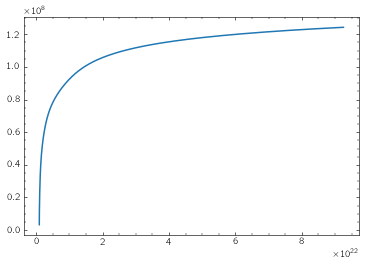

In [886]:
_r,_v,_rho,_P,_rhoZ = Utils.ntuple2array(res.pre_wind_info)

r_ = sol.t
v_ = sol.y[0]
rho_ = sol.y[1]
P_ = sol.y[2]
rhoZ_ = sol.y[3]
M_cloud = sol.y[4]
v_cloud = sol.y[5]
Z_cloud = sol.y[6]

r = np.r_[_r,r_]
v = np.r_[_v,v_]
P = np.r_[_P,P_]
rho = np.r_[_rho,rho_]
rhoZ = _rhoZ, rhoZ_

plt.plot(r_,v_cloud)

Text(0.5, 1.0, 'Numerical Solutions for Hot Wind')

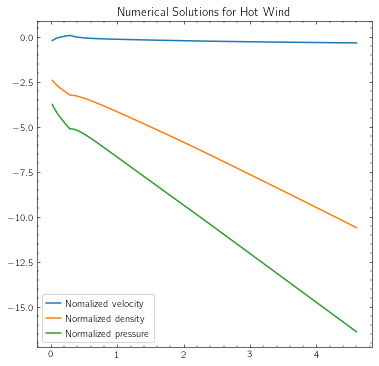

In [887]:
R=pm['SONIC_POINT']
u_star = v_/(pm['MDOT']**-0.5 * pm['EDOT']**0.5)
rho_star = rho_/(pm['MDOT']**1.5 * pm['EDOT']**-0.5 * R**-2)
P_star = P_/(pm['MDOT']**0.5 * pm['EDOT']**0.5 * R**-2)
plt.figure(figsize=(6,6))
plt.plot(np.log(r_/R),np.log(u_star), label='Nomalized velocity')
plt.plot(np.log(r_/R),np.log(rho_star), label = 'Normalized density')
plt.plot(np.log(r_/R),np.log(P_star), label = 'Normalized pressure')
plt.legend()
plt.title('Numerical Solutions for Hot Wind')

In [890]:
dump_wind_test = 1
dump_cloud_test = 1
dump_source_test = 0

init = np.r_[249284844.32131106, 2.6572708207234414e-26, 2.0050282916542196e-10, 1.0629083282893774e-27, 2.e+36, 3162277.66016652, 0.02]
start = 400
end = 2100
samples = 403
#delta = round((end - start)/samples)
sched = [(start + i)*pc for i in range(samples)]
def gen_sched(i, nbs, a, start, end):
    return (end - start) * (np.exp(-a*(nbs + 1/10**10 - i)))+start

r = [gen_sched(i, samples, 0.003, start, end) for i in range(samples+1)]
r.append(end + pc)
r = sched


res = [init]
istate = init
for i in range(len(r)-1):
    state = istate
    dr = r[i+1] - r[i]
    dot = evolve_check(r[i], state)
    v = state[0] + dot[0] * dr
    rho = state[1] + dot[1] * dr
    P = state[2] + dot[2] * dr
    rhoz = state[3] + dot[3] * dr
    Mcl = state[4] + dot[4] * dr
    vcl = state[5] + dot[5] * dr
    Zcl = state[6] + dot[6] * dr
    istate = np.r_[v, rho,P,rhoz, Mcl,vcl,Zcl]
    res.append(istate)    

#WIND_TEST 2100 163515494.70245656 2.9039797566772074e-27 3.808289462032312e-12 8.333327580399206e-29
#CLOUD_TEST 2100 1.1816019069713489e+36 75172913.57771112 3.1967622932590885e-63 0.025076780359785403 
    

#WIND_TEST 2100 185669236.61144087 2.1234627335732608e-27 3.3757980078687202e-12 6.62192390879595e-29
#CLOUD_TEST 2100 1.0710258743733522e+36 83499601.50530697 2.876735275499474e-63 0.02635595050142518

WIND_TEST 400 249284844.32131106 2.6572708207234414e-26 2.0050282916542196e-10 1.0629083282893774e-27
CLOUD_TEST 400 2e+36 3162277.66016652 2.0947475650243223e-60 0.02
WIND_TEST 401 232351018.5131261 2.8929194134525543e-26 2.4009013218578274e-10 1.1340864090447762e-27
CLOUD_TEST 401 1.9742489407199536e+36 5293132.022724521 1.2452318067366102e-60 0.020176795089489975
WIND_TEST 402 223735402.51123723 3.0247754599062006e-26 2.6117171460705527e-10 1.172808751252676e-27
CLOUD_TEST 402 1.960495573991204e+36 6434455.829079344 1.0192664912138904e-60 0.0202758125019782
WIND_TEST 403 217268965.0978014 3.128303864511748e-26 2.7723001070987506e-10 1.2026560523282203e-27
CLOUD_TEST 403 1.9498674734040517e+36 7322732.815272397 8.91186084020508e-61 0.020354661890237442
WIND_TEST 404 211996938.6151473 3.2153779267733176e-26 2.9038215055461333e-10 1.227345188566278e-27
CLOUD_TEST 404 1.9409811998181487e+36 8070751.377179957 8.045906433159366e-61 0.020422236672890705
WIND_TEST 405 207519515.57811058 3.2

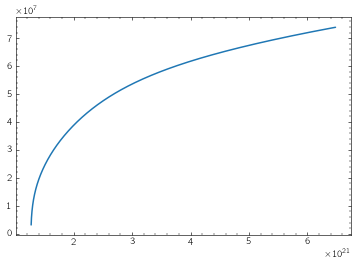

In [813]:
q = Utils.ntuple2array(res)[5]
plt.plot(np.array(r), q)

In [731]:
r = 

array([ 3162277.66016652,  3162277.66016652,  3162277.66016652, ...,
       37172481.1207969 , 47947198.43482385, 61965202.25086913])

In [754]:
def gen_sched(i, nbs, a, start, end):
    return (end - start) * (np.exp(-a*(nbs + 1/10**10 - i)))+start

r = [gen_sched(i, samples, 0.4, start, end) for i in range(samples+1)]

In [755]:
np.array(r)/pc

array([ 400.        ,  400.        ,  400.        , ..., 1163.90417187,
       1539.61111022, 2100.09999993])

In [820]:
start = 400 * pc
end = 2100.1 * pc
samples = 1000
#delta = round((end - start)/samples)
#sched = [start + (1*pc)*i for i in range(samples)]
def gen_sched(i, nbs, a, start, end):
    return (end - start) * (np.exp(-a*(nbs + 1/10**10 - i)))+start

r = [gen_sched(i, samples, 0.003, start, end) for i in range(samples+1)]

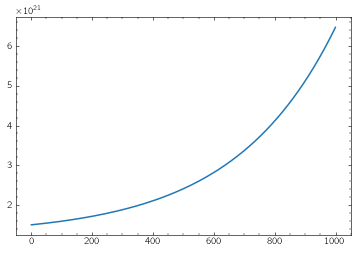

In [821]:
i = range(samples+1)
plt.plot(i,r)

In [876]:
start = 400
end = 2100
samples = 1
#delta = round((end - start)/samples)
sched = [(start + i)*pc for i in range(samples)]
def gen_sched(i, nbs, a, start, end):
    return (end - start) * (np.exp(-a*(nbs + 1/10**10 - i)))+start

r = [gen_sched(i, samples, 0.003, start, end) for i in range(samples+1)]
r.append(end)
#r = sched

In [877]:
np.array(r)/pc

array([6.78842399e-16, 6.80492547e-16, 6.80492547e-16])

In [883]:
round(0.9)

1